<a href="https://colab.research.google.com/github/pratbat05/tensor/blob/main/vis_tensor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install numpy matplotlib scipy pandas pyvista

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.3/112.3 MB 9.4 MB/s eta 0:00:00


<>:212: SyntaxWarning: invalid escape sequence '\g'
<>:290: SyntaxWarning: invalid escape sequence '\e'
<>:212: SyntaxWarning: invalid escape sequence '\g'
<>:290: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipython-input-1997209248.py:212: SyntaxWarning: invalid escape sequence '\g'
  ax.set_xlabel('Total Shear ($\gamma$)')
/tmp/ipython-input-1997209248.py:290: SyntaxWarning: invalid escape sequence '\e'
  ax.set_xlabel('Total Elongation ($\epsilon$)')


Generating legacy VTK data files for ParaView...
Legacy VTK data saved to orientation_tensors_shear_ap10_legacy.vtk
Legacy VTK data saved to orientation_tensors_elongation_ap10_legacy.vtk

Starting Matplotlib plotting for Simple Shear Flow...

--- Simple Shear Flow: RMSE and MAPE Errors ---
  A2 Model $S_{1111}$ (ap=10): RMSE = 0.044438, MAPE = 5.19%
  A4 Model $S_{1111}$ (ap=10): RMSE = 0.047842, MAPE = 5.36%
  A2 Model $S_{1112}$ (ap=10): RMSE = 0.038560, MAPE = 19.19%
  A4 Model $S_{1112}$ (ap=10): RMSE = 0.047594, MAPE = 26.22%
  A2 Model $S_{1122}$ (ap=10): RMSE = 0.033160, MAPE = 55.02%
  A4 Model $S_{1122}$ (ap=10): RMSE = 0.011617, MAPE = 50.31%
  A2 Model $S_{2222}$ (ap=10): RMSE = 0.055274, MAPE = 91.58%
  A4 Model $S_{2222}$ (ap=10): RMSE = 0.045782, MAPE = 90.09%


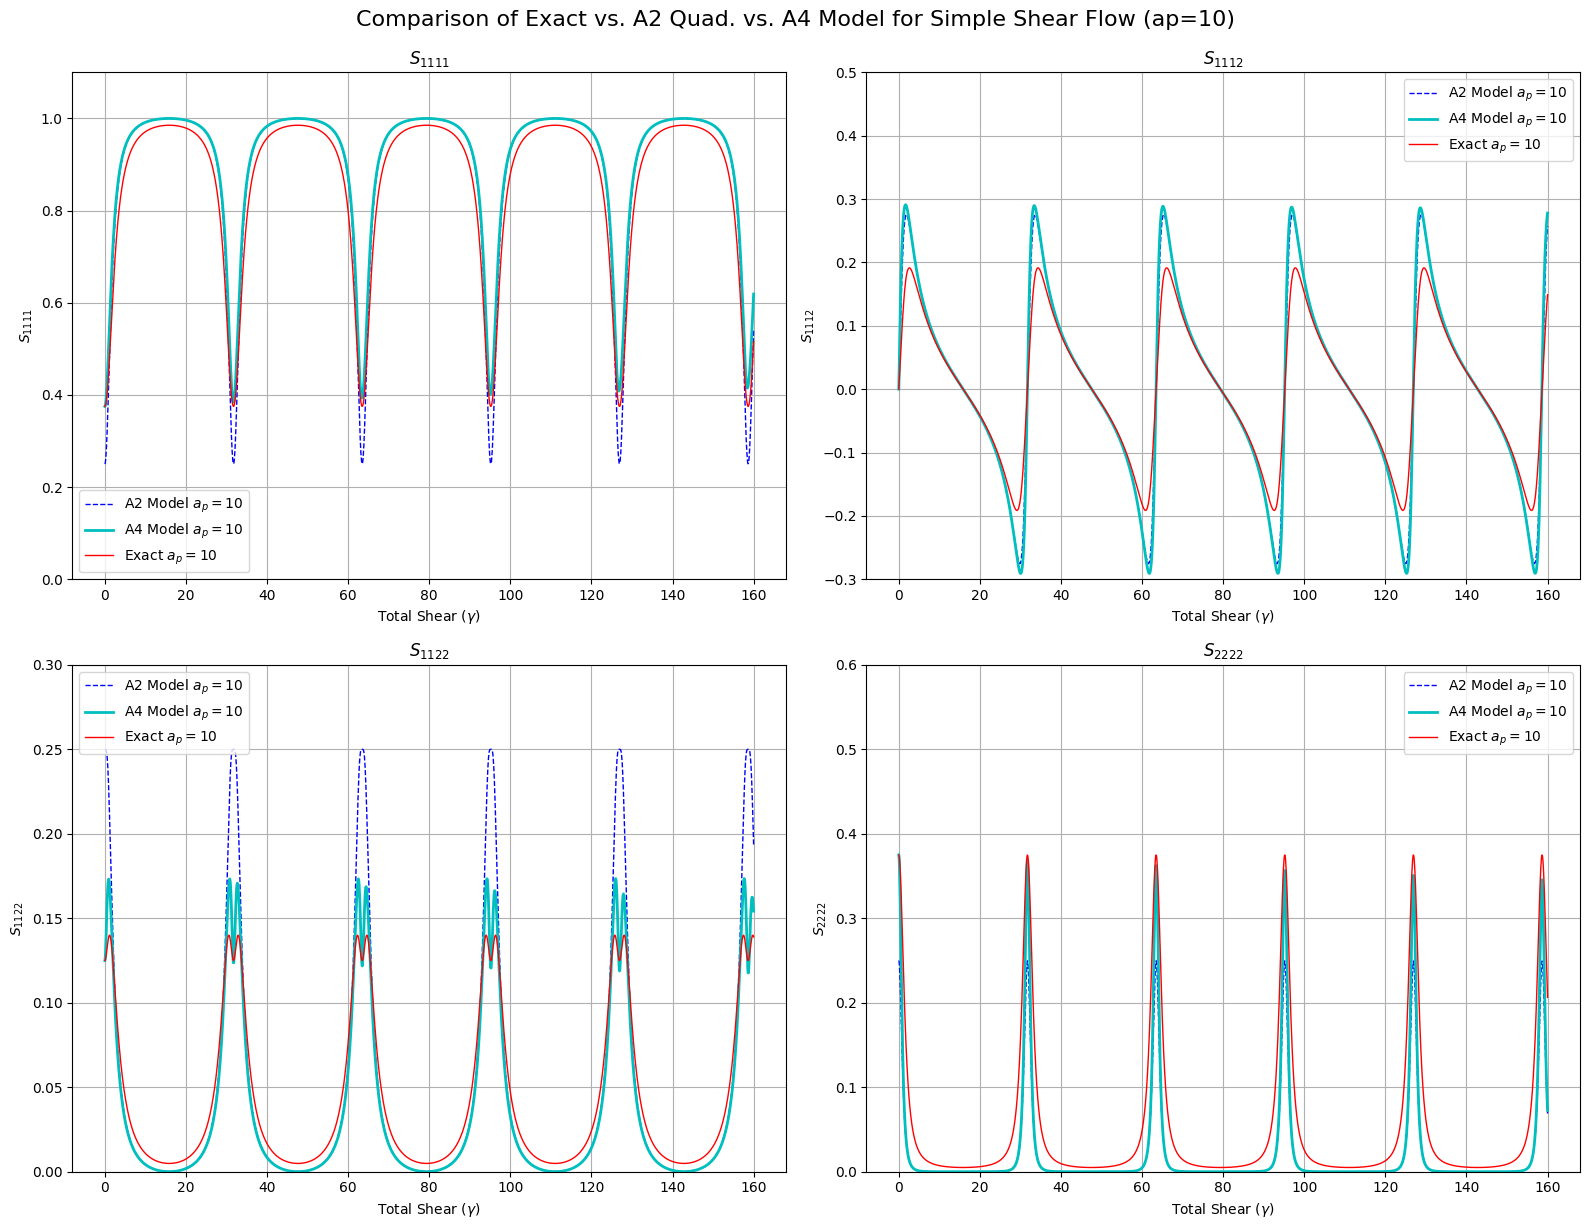


Starting Matplotlib plotting for Planar Elongational Flow...

--- Planar Elongational Flow: RMSE and MAPE Errors ---
  A2 Model $S_{1111}$ (ap=10): RMSE = 0.086731, MAPE = 9.22%
  A4 Model $S_{1111}$ (ap=10): RMSE = 0.134953, MAPE = 14.52%
  A2 Model $S_{1112}$ (ap=10): RMSE = 0.000000, MAPE = nan%
  A4 Model $S_{1112}$ (ap=10): RMSE = 0.000000, MAPE = nan%
  A2 Model $S_{1122}$ (ap=10): RMSE = 0.038829, MAPE = 77.80%
  A4 Model $S_{1122}$ (ap=10): RMSE = 0.031381, MAPE = 81.71%
  A2 Model $S_{2222}$ (ap=10): RMSE = 0.086739, MAPE = 94.17%
  A4 Model $S_{2222}$ (ap=10): RMSE = 0.076272, MAPE = 91.94%


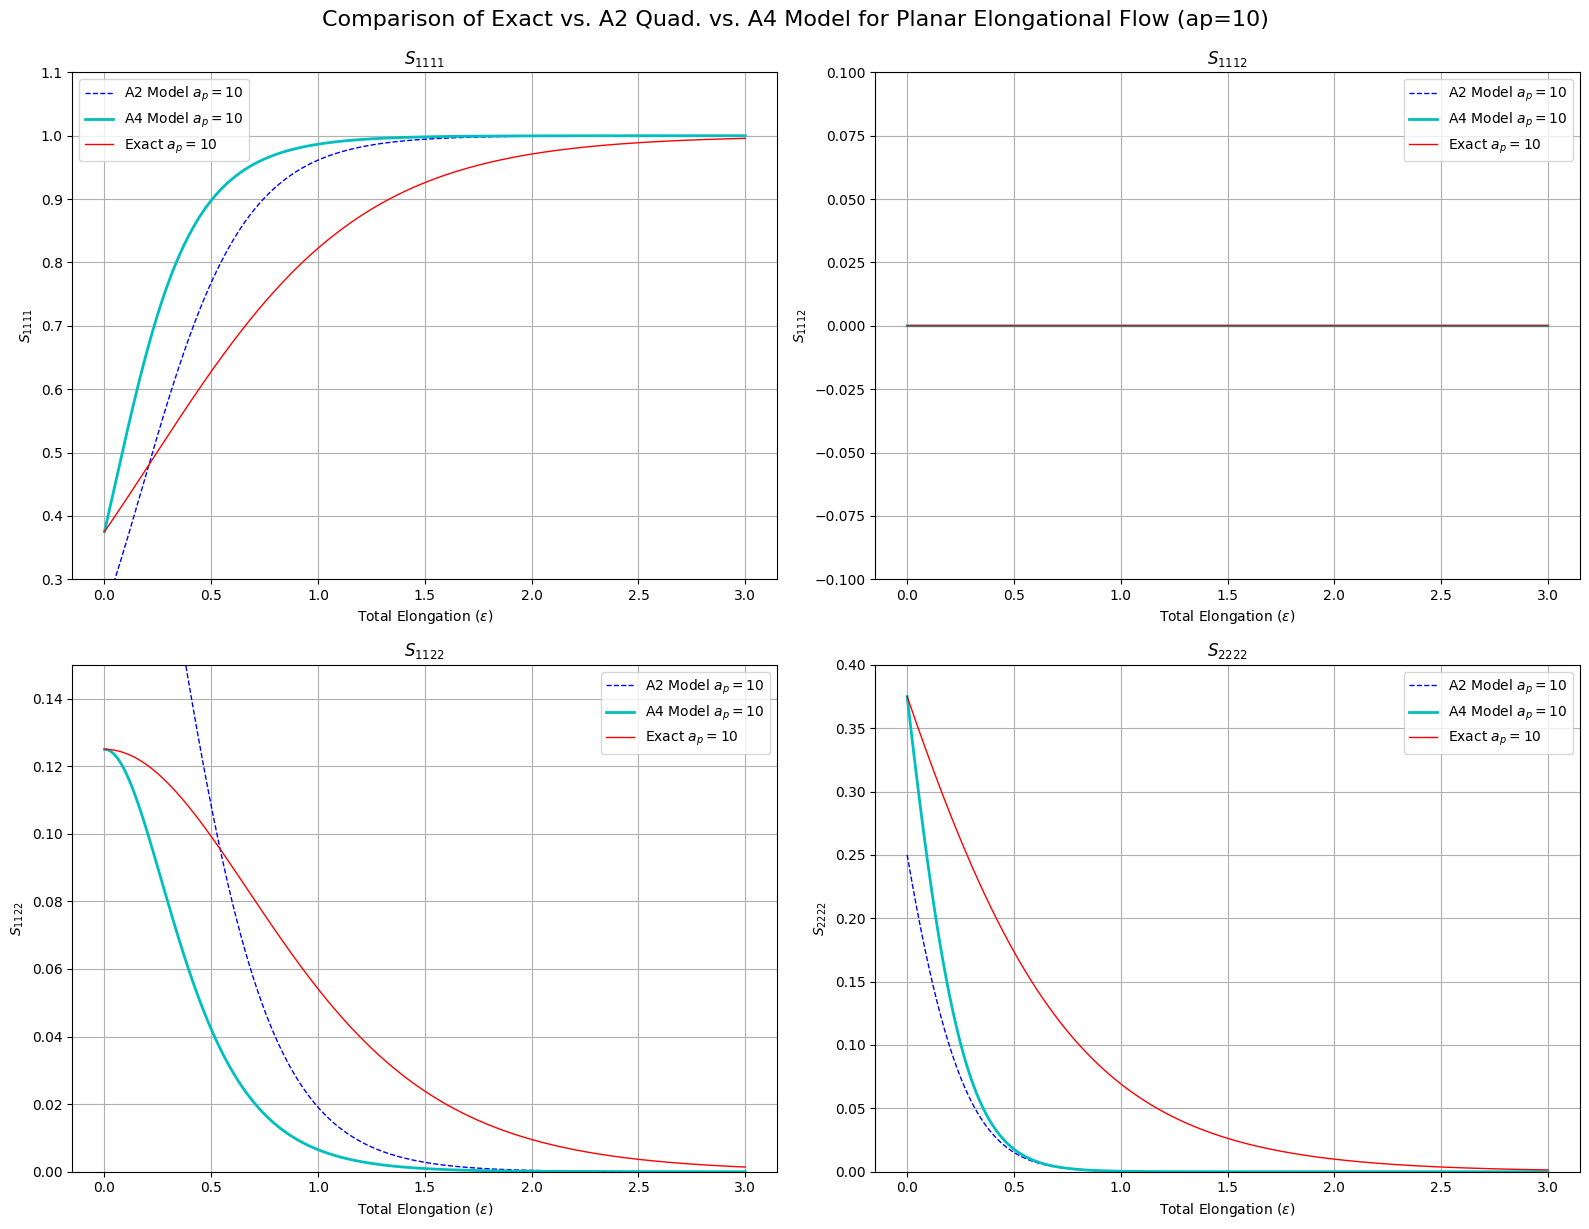


Data generated and saved. You can now open these VTK files in ParaView:
- orientation_tensors_shear_ap10_legacy.vtk
- orientation_tensors_elongation_ap10_legacy.vtk

Follow the instructions from the previous response to visualize tensors using glyphs.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import pandas as pd
import pyvista as pv

A_RANDOM_INITIAL_2D = np.array([[0.5, 0.0],
                                [0.0, 0.5]])

S_1111_RANDOM = 0.375
S_1112_RANDOM = 0.0
S_1122_RANDOM = 0.125
S_2222_RANDOM = 0.375
S_1222_RANDOM = 0.0

A4_RANDOM_INITIAL_FLAT = np.array([
    S_1111_RANDOM,
    S_1112_RANDOM,
    S_1122_RANDOM,
    S_1222_RANDOM,
    S_2222_RANDOM
])

EPSILON = 1e-10

def calculate_lambda(ap):
    if ap == 1:
        return 0.0
    else:
        return (ap**2 - 1) / (ap**2 + 1)

def get_L_simple_shear_2d(shear_rate):
    return np.array([[0, shear_rate],
                     [0, 0]])

def get_L_planar_elongational_2d(strain_rate):
    return np.array([[strain_rate, 0],
                     [0, -strain_rate]])

def quadratic_closure_A4_for_A2_model(A2_tensor):
    A = A2_tensor
    A4_closed = np.einsum('ik,jl->ijkl', A, A)
    return A4_closed

def jeffrey_ode_func_2d(A_flat, t, L_tensor, lambda_val):
    A = A_flat.reshape((2, 2))
    W = 0.5 * (L_tensor - L_tensor.T)
    D = 0.5 * (L_tensor + L_tensor.T)
    L_prime_tensor = W + lambda_val * D
    term_L_prime_S = np.einsum('im,mj->ij', L_prime_tensor, A) + \
                     np.einsum('jm,mi->ij', L_prime_tensor, A)
    closure_term = -2 * lambda_val * np.einsum('kl,kl->', D, A) * A
    dA_dt = term_L_prime_S + closure_term
    return dA_dt.flatten()

def A4_from_A2_quadratic_closure(A2_tensor):
    A11 = A2_tensor[0, 0]
    A12 = A2_tensor[0, 1]
    A22 = A2_tensor[1, 1]
    S1111_approx = A11 * A11
    S1112_approx = A11 * A12
    S1122_approx = A11 * A22
    S2222_approx = A22 * A22
    return S1111_approx, S1112_approx, S1122_approx, S2222_approx

def reconstruct_A4(A4_flat):
    A4 = np.zeros((2,2,2,2))
    A1111, A1112, A1122, A1222, A2222 = A4_flat
    A4[0,0,0,0] = A1111
    A4[0,0,0,1] = A1112; A4[0,0,1,0] = A1112; A4[0,1,0,0] = A1112; A4[1,0,0,0] = A1112
    A4[0,0,1,1] = A1122; A4[0,1,0,1] = A1122; A4[0,1,1,0] = A1122; A4[1,0,0,1] = A1122; A4[1,0,1,0] = A1122; A4[1,1,0,0] = A1122
    A4[1,1,1,1] = A2222
    A4[0,1,1,1] = A1222; A4[1,0,1,1] = A1222; A4[1,1,0,1] = A1222; A4[1,1,1,0] = A1222
    return A4

def get_A2_from_A4(A4_tensor):
    A2 = np.zeros((2,2))
    A2[0,0] = A4_tensor[0,0,0,0] + A4_tensor[0,1,1,0]
    A2[0,1] = A4_tensor[0,0,0,1] + A4_tensor[0,1,1,1]
    A2[1,0] = A4_tensor[1,0,0,0] + A4_tensor[1,1,1,0]
    A2[1,1] = A4_tensor[1,0,0,1] + A4_tensor[1,1,1,1]
    return A2

def jeffrey_ode_func_A4(A4_flat, t, L_tensor, lambda_val):
    A4 = reconstruct_A4(A4_flat)
    A2 = get_A2_from_A4(A4)
    W = 0.5 * (L_tensor - L_tensor.T)
    D = 0.5 * (L_tensor + L_tensor.T)
    L_prime_tensor = W + lambda_val * D
    term_hydrodynamic = np.einsum('im,mjkl->ijkl', L_prime_tensor, A4) + \
                        np.einsum('jm,imkl->ijkl', L_prime_tensor, A4) + \
                        np.einsum('km,ijml->ijkl', L_prime_tensor, A4) + \
                        np.einsum('lm,ijkm->ijkl', L_prime_tensor, A4)
    closure_term_A6 = -4 * lambda_val * np.einsum('rs,rs->', D, A2) * A4
    dA4_dt_tensor = term_hydrodynamic + closure_term_A6
    d_A4_dt_flat = np.array([
        dA4_dt_tensor[0,0,0,0],
        dA4_dt_tensor[0,0,0,1],
        dA4_dt_tensor[0,0,1,1],
        dA4_dt_tensor[0,1,1,1],
        dA4_dt_tensor[1,1,1,1]
    ])
    return d_A4_dt_flat

def calculate_shear_params_exact(gamma, ap):
    lam = calculate_lambda(ap)
    if np.isclose(lam, 1.0):
        wt_val = 0.0
    else:
        wt_val = (gamma / 2) * np.sqrt(1 - lam**2 + EPSILON)
    a1 = 1 - (2 * lam / (1 + lam)) * np.sin(wt_val)**2
    a2 = - (2 * lam / np.sqrt(1 - lam**2 + EPSILON)) * np.sin(2 * wt_val)
    a3 = 1 + (2 * lam / (1 - lam + EPSILON)) * np.sin(wt_val)**2
    return a1, a2, a3, wt_val

def S_ijkl_shear_exact(gamma, ap):
    if np.isclose(gamma, 0.0):
        return S_1111_RANDOM, S_1112_RANDOM, S_1122_RANDOM, S_1222_RANDOM, S_2222_RANDOM
    a1, a2, a3, wt_val = calculate_shear_params_exact(gamma, ap)
    if ap != 1 and np.isclose(np.sin(wt_val), 0.0, atol=1e-3):
         return S_1111_RANDOM, S_1112_RANDOM, S_1122_RANDOM, S_1222_RANDOM, S_2222_RANDOM
    common_denom_term = (a1 + a3)**2 - 4
    if np.isclose(common_denom_term, 0.0, atol=EPSILON):
        return S_1111_RANDOM, S_1112_RANDOM, S_1122_RANDOM, S_1222_RANDOM, S_2222_RANDOM
    S1111 = (a1 + a3 - 2)**2 * (4 + a1 + 5 * a3 + 2 * a3**2) / (2 * common_denom_term**2 + EPSILON)
    S1112 = - (a1 + a3 - 2)**2 * a2 * (1 + a3) / (2 * common_denom_term**2 + EPSILON)
    S1122 = (a1 + a3 - 2)**2 * (a1 + 2 * a1 * a3 + a3) / (2 * common_denom_term**2 + EPSILON)
    S1222 = - (a1 + a3 - 2)**2 * a2 * (1 + a3) / (2 * common_denom_term**2 + EPSILON)
    S2222 = (a1 + a3 - 2)**2 * (4 + 2 * a1**2 + 5 * a1 + a3) / (2 * common_denom_term**2 + EPSILON)
    return S1111, S1112, S1122, S1222, S2222

def calculate_elongation_params_exact(epsilon, ap):
    lam = calculate_lambda(ap)
    wt_val = lam * epsilon
    a1 = np.exp(-2 * wt_val)
    a2 = 0.0
    a3 = np.exp(2 * wt_val)
    return a1, a2, a3

def S_ijkl_elongation_exact(epsilon, ap):
    if np.isclose(epsilon, 0.0):
        return S_1111_RANDOM, S_1112_RANDOM, S_1122_RANDOM, S_1222_RANDOM, S_2222_RANDOM
    a1, a2, a3 = calculate_elongation_params_exact(epsilon, ap)
    common_denom_term = (a1 - a3)**2
    if np.isclose(common_denom_term, 0.0, atol=EPSILON):
        return S_1111_RANDOM, S_1112_RANDOM, S_1122_RANDOM, S_1222_RANDOM, S_2222_RANDOM
    S1111 = (a1 - 3 * a3 + 2 * a3**2) / (2 * common_denom_term + EPSILON)
    S1112 = 0.0
    S1122 = (a1 - 2 * a1 * a3 + a3) / (2 * common_denom_term + EPSILON)
    S1222 = 0.0
    S2222 = (2 * a1**2 - 3 * a1 + a3) / (2 * common_denom_term + EPSILON)
    return S1111, S1112, S1122, S1222, S2222

def calculate_mape(exact_values, predicted_values, threshold=1e-8):
    exact_np = np.array(exact_values)
    predicted_np = np.array(predicted_values)
    valid_indices = np.abs(exact_np) > threshold
    if np.sum(valid_indices) == 0:
        return np.nan
    percentage_errors = (np.abs(predicted_np[valid_indices] - exact_np[valid_indices]) / np.abs(exact_np[valid_indices])) * 100
    return np.mean(percentage_errors)

def save_tensor_data_to_vtk_legacy(flow_type, ap):
    if flow_type == 'shear':
        time_points = np.linspace(0, 160, 2000)
        shear_rate_val = 1.0
        L_flow = get_L_simple_shear_2d(shear_rate=shear_rate_val)
    elif flow_type == 'elongation':
        time_points = np.linspace(0, 3.0, 2000)
        strain_rate_val = 1.0
        L_flow = get_L_planar_elongational_2d(strain_rate=strain_rate_val)
    else:
        raise ValueError("Invalid flow_type. Choose 'shear' or 'elongation'.")
    lam = calculate_lambda(ap)
    sol_A4 = odeint(jeffrey_ode_func_A4, A4_RANDOM_INITIAL_FLAT, time_points, args=(L_flow, lam))
    A_ij_A4_model = []
    for a4_flat in sol_A4:
        a4_tensor = reconstruct_A4(a4_flat)
        a2_tensor = get_A2_from_A4(a4_tensor)
        A_ij_A4_model.append(a2_tensor.flatten())
    A_ij_A4_model = np.array(A_ij_A4_model)
    points = np.zeros((len(time_points), 3))
    points[:, 0] = time_points
    mesh = pv.PolyData(points)
    A_tensor_3x3_A4 = np.zeros((len(time_points), 9))
    A_tensor_3x3_A4[:, 0] = A_ij_A4_model[:, 0]
    A_tensor_3x3_A4[:, 1] = A_ij_A4_model[:, 3]
    A_tensor_3x3_A4[:, 3] = A_ij_A4_model[:, 1]
    A_tensor_3x3_A4[:, 6] = A_ij_A4_model[:, 2]
    mesh[f'A_ij_tensor'] = A_tensor_3x3_A4
    file_name = f'orientation_tensors_{flow_type}_ap{ap}_legacy.vtk'
    mesh.save(file_name)
    print(f"Legacy VTK data saved to {file_name}")
    return file_name

def plot_comparison_shear_all_models():
    shear_rates = np.linspace(0, 160, 2000)
    aspect_ratios = [10]
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    component_titles = ['$S_{1111}$', '$S_{1112}$', '$S_{1122}$', '$S_{2222}$']
    y_limits_shear = {
        '$S_{1111}$': (0.0, 1.1),
        '$S_{1112}$': (-0.3, 0.5),
        '$S_{1122}$': (0.0, 0.3),
        '$S_{2222}$': (0.0, 0.6)
    }
    print("\n--- Simple Shear Flow: RMSE and MAPE Errors ---")
    for i, title in enumerate(component_titles):
        ax = axes[i]
        ax.set_title(title)
        ax.set_xlabel('Total Shear ($\gamma$)')
        ax.set_ylabel(title)
        ax.grid(True)
        ax.set_ylim(y_limits_shear[title])
        for ap in aspect_ratios:
            lam = calculate_lambda(ap)
            shear_rate_val = 1.0
            L_shear = get_L_simple_shear_2d(shear_rate=shear_rate_val)
            sol_quad_a2 = odeint(jeffrey_ode_func_2d, A_RANDOM_INITIAL_2D.flatten(), shear_rates, args=(L_shear, lam))
            ode_s_data_quad_a2 = []
            for j, gamma in enumerate(shear_rates):
                A_current = sol_quad_a2[j].reshape((2, 2))
                s1111, s1112, s1122, s2222 = A4_from_A2_quadratic_closure(A_current)
                if title == '$S_{1111}$': ode_s_data_quad_a2.append(s1111)
                elif title == '$S_{1112}$': ode_s_data_quad_a2.append(s1112)
                elif title == '$S_{1122}$': ode_s_data_quad_a2.append(s1122)
                elif title == '$S_{2222}$': ode_s_data_quad_a2.append(s2222)
            ax.plot(shear_rates, ode_s_data_quad_a2, 'b--', label=f'A2 Model $a_p={ap}$', linewidth=1)
            sol_A4 = odeint(jeffrey_ode_func_A4, A4_RANDOM_INITIAL_FLAT, shear_rates, args=(L_shear, lam))
            ode_s_data_A4 = []
            for j, gamma in enumerate(shear_rates):
                A4_current_flat = sol_A4[j]
                A4_current = reconstruct_A4(A4_current_flat)
                s1111 = A4_current[0,0,0,0]
                s1112 = A4_current[0,0,0,1]
                s1122 = A4_current[0,0,1,1]
                s2222 = A4_current[1,1,1,1]
                if title == '$S_{1111}$': ode_s_data_A4.append(s1111)
                elif title == '$S_{1112}$': ode_s_data_A4.append(s1112)
                elif title == '$S_{1122}$': ode_s_data_A4.append(s1122)
                elif title == '$S_{2222}$': ode_s_data_A4.append(s2222)
            ax.plot(shear_rates, ode_s_data_A4, 'c-', label=f'A4 Model $a_p={ap}$', linewidth=2)
            exact_s_data = []
            for gamma in shear_rates:
                s1111, s1112, s1122, s1222, s2222_exact = S_ijkl_shear_exact(gamma, ap)
                if title == '$S_{1111}$': exact_s_data.append(s1111)
                elif title == '$S_{1112}$': exact_s_data.append(s1112)
                elif title == '$S_{1122}$': exact_s_data.append(s1122)
                elif title == '$S_{2222}$': exact_s_data.append(s2222_exact)
            ax.plot(shear_rates, exact_s_data, 'r-', label=f'Exact $a_p={ap}$', linewidth=1)
            ode_data_np_quad_a2 = np.array(ode_s_data_quad_a2)
            ode_data_np_A4 = np.array(ode_s_data_A4)
            exact_data_np = np.array(exact_s_data)
            valid_indices_rmse = ~np.isnan(ode_data_np_quad_a2) & ~np.isnan(exact_data_np)
            if np.sum(valid_indices_rmse) > 0:
                rmse_quad_a2 = np.sqrt(np.mean((ode_data_np_quad_a2[valid_indices_rmse] - exact_data_np[valid_indices_rmse])**2))
            else:
                rmse_quad_a2 = np.nan
            mape_quad_a2 = calculate_mape(exact_data_np, ode_data_np_quad_a2)
            print(f"  A2 Model {title} (ap={ap}): RMSE = {rmse_quad_a2:.6f}, MAPE = {mape_quad_a2:.2f}%")
            valid_indices_rmse = ~np.isnan(ode_data_np_A4) & ~np.isnan(exact_data_np)
            if np.sum(valid_indices_rmse) > 0:
                rmse_A4 = np.sqrt(np.mean((ode_data_np_A4[valid_indices_rmse] - exact_data_np[valid_indices_rmse])**2))
            else:
                rmse_A4 = np.nan
            mape_A4 = calculate_mape(exact_data_np, ode_data_np_A4)
            print(f"  A4 Model {title} (ap={ap}): RMSE = {rmse_A4:.6f}, MAPE = {mape_A4:.2f}%")
        ax.legend()
    plt.tight_layout()
    plt.suptitle('Comparison of Exact vs. A2 Quad. vs. A4 Model for Simple Shear Flow (ap=10)', y=1.02, fontsize=16)
    plt.show()

def plot_comparison_elongational_all_models():
    elongation_rates = np.linspace(0, 3.0, 2000)
    aspect_ratios = [10]
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    component_titles = ['$S_{1111}$', '$S_{1112}$', '$S_{1122}$', '$S_{2222}$']
    y_limits_elongational = {
        '$S_{1111}$': (0.3, 1.1),
        '$S_{1112}$': (-0.1, 0.1),
        '$S_{1122}$': (0.0, 0.15),
        '$S_{2222}$': (0.0, 0.4)
    }
    print("\n--- Planar Elongational Flow: RMSE and MAPE Errors ---")
    for i, title in enumerate(component_titles):
        ax = axes[i]
        ax.set_title(title)
        ax.set_xlabel('Total Elongation ($\epsilon$)')
        ax.set_ylabel(title)
        ax.grid(True)
        ax.set_ylim(y_limits_elongational[title])
        for ap in aspect_ratios:
            lam = calculate_lambda(ap)
            strain_rate_val = 1.0
            L_elong = get_L_planar_elongational_2d(strain_rate=strain_rate_val)
            sol_quad_a2 = odeint(jeffrey_ode_func_2d, A_RANDOM_INITIAL_2D.flatten(), elongation_rates, args=(L_elong, lam))
            ode_s_data_quad_a2 = []
            for j, epsilon in enumerate(elongation_rates):
                A_current = sol_quad_a2[j].reshape((2, 2))
                s1111, s1112, s1122, s2222 = A4_from_A2_quadratic_closure(A_current)
                if title == '$S_{1111}$': ode_s_data_quad_a2.append(s1111)
                elif title == '$S_{1112}$': ode_s_data_quad_a2.append(s1112)
                elif title == '$S_{1122}$': ode_s_data_quad_a2.append(s1122)
                elif title == '$S_{2222}$': ode_s_data_quad_a2.append(s2222)
            ax.plot(elongation_rates, ode_s_data_quad_a2, 'b--', label=f'A2 Model $a_p={ap}$', linewidth=1)
            sol_A4 = odeint(jeffrey_ode_func_A4, A4_RANDOM_INITIAL_FLAT, elongation_rates, args=(L_elong, lam))
            ode_s_data_A4 = []
            for j, epsilon in enumerate(elongation_rates):
                A4_current_flat = sol_A4[j]
                A4_current = reconstruct_A4(A4_current_flat)
                s1111 = A4_current[0,0,0,0]
                s1112 = A4_current[0,0,0,1]
                s1122 = A4_current[0,0,1,1]
                s2222 = A4_current[1,1,1,1]
                if title == '$S_{1111}$': ode_s_data_A4.append(s1111)
                elif title == '$S_{1112}$': ode_s_data_A4.append(s1112)
                elif title == '$S_{1122}$': ode_s_data_A4.append(s1122)
                elif title == '$S_{2222}$': ode_s_data_A4.append(s2222)
            ax.plot(elongation_rates, ode_s_data_A4, 'c-', label=f'A4 Model $a_p={ap}$', linewidth=2)
            exact_s_data = []
            for epsilon in elongation_rates:
                s1111, s1112, s1122, s1222, s2222_exact = S_ijkl_elongation_exact(epsilon, ap)
                if title == '$S_{1111}$': exact_s_data.append(s1111)
                elif title == '$S_{1112}$': exact_s_data.append(s1112)
                elif title == '$S_{1122}$': exact_s_data.append(s1122)
                elif title == '$S_{2222}$': exact_s_data.append(s2222_exact)
            ax.plot(elongation_rates, exact_s_data, 'r-', label=f'Exact $a_p={ap}$', linewidth=1)
            ode_data_np_quad_a2 = np.array(ode_s_data_quad_a2)
            ode_data_np_A4 = np.array(ode_s_data_A4)
            exact_data_np = np.array(exact_s_data)
            valid_indices_rmse = ~np.isnan(ode_data_np_quad_a2) & ~np.isnan(exact_data_np)
            if np.sum(valid_indices_rmse) > 0:
                rmse_quad_a2 = np.sqrt(np.mean((ode_data_np_quad_a2[valid_indices_rmse] - exact_data_np[valid_indices_rmse])**2))
            else:
                rmse_quad_a2 = np.nan
            mape_quad_a2 = calculate_mape(exact_data_np, ode_data_np_quad_a2)
            print(f"  A2 Model {title} (ap={ap}): RMSE = {rmse_quad_a2:.6f}, MAPE = {mape_quad_a2:.2f}%")
            valid_indices_rmse = ~np.isnan(ode_data_np_A4) & ~np.isnan(exact_data_np)
            if np.sum(valid_indices_rmse) > 0:
                rmse_A4 = np.sqrt(np.mean((ode_data_np_A4[valid_indices_rmse] - exact_data_np[valid_indices_rmse])**2))
            else:
                rmse_A4 = np.nan
            mape_A4 = calculate_mape(exact_data_np, ode_data_np_A4)
            print(f"  A4 Model {title} (ap={ap}): RMSE = {rmse_A4:.6f}, MAPE = {mape_A4:.2f}%")
        ax.legend()
    plt.tight_layout()
    plt.suptitle('Comparison of Exact vs. A2 Quad. vs. A4 Model for Planar Elongational Flow (ap=10)', y=1.02, fontsize=16)
    plt.show()

if __name__ == "__main__":
    ap = 10
    print("Generating legacy VTK data files for ParaView...")
    shear_vtk = save_tensor_data_to_vtk_legacy('shear', ap)
    elongation_vtk = save_tensor_data_to_vtk_legacy('elongation', ap)

    print("\nStarting Matplotlib plotting for Simple Shear Flow...")
    plot_comparison_shear_all_models()
    print("\nStarting Matplotlib plotting for Planar Elongational Flow...")
    plot_comparison_elongational_all_models()

    print("\nData generated and saved. You can now open these VTK files in ParaView:")
    print(f"- {shear_vtk}")
    print(f"- {elongation_vtk}")
    print("\nFollow the instructions from the previous response to visualize tensors using glyphs.")

<>:215: SyntaxWarning: invalid escape sequence '\g'
<>:293: SyntaxWarning: invalid escape sequence '\e'
<>:215: SyntaxWarning: invalid escape sequence '\g'
<>:293: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipython-input-950861987.py:215: SyntaxWarning: invalid escape sequence '\g'
  ax.set_xlabel('Total Shear ($\gamma$)')
/tmp/ipython-input-950861987.py:293: SyntaxWarning: invalid escape sequence '\e'
  ax.set_xlabel('Total Elongation ($\epsilon$)')


Generating legacy VTK ASCII data files for ParaView...
Legacy VTK data saved to orientation_tensors_shear_ap10_legacy_ascii.vtk
Legacy VTK data saved to orientation_tensors_elongation_ap10_legacy_ascii.vtk

Starting Matplotlib plotting for Simple Shear Flow...

--- Simple Shear Flow: RMSE and MAPE Errors ---
  A2 Model $S_{1111}$ (ap=10): RMSE = 0.044438, MAPE = 5.19%
  A4 Model $S_{1111}$ (ap=10): RMSE = 0.047842, MAPE = 5.36%
  A2 Model $S_{1112}$ (ap=10): RMSE = 0.038560, MAPE = 19.19%
  A4 Model $S_{1112}$ (ap=10): RMSE = 0.047594, MAPE = 26.22%
  A2 Model $S_{1122}$ (ap=10): RMSE = 0.033160, MAPE = 55.02%
  A4 Model $S_{1122}$ (ap=10): RMSE = 0.011617, MAPE = 50.31%
  A2 Model $S_{2222}$ (ap=10): RMSE = 0.055274, MAPE = 91.58%
  A4 Model $S_{2222}$ (ap=10): RMSE = 0.045782, MAPE = 90.09%


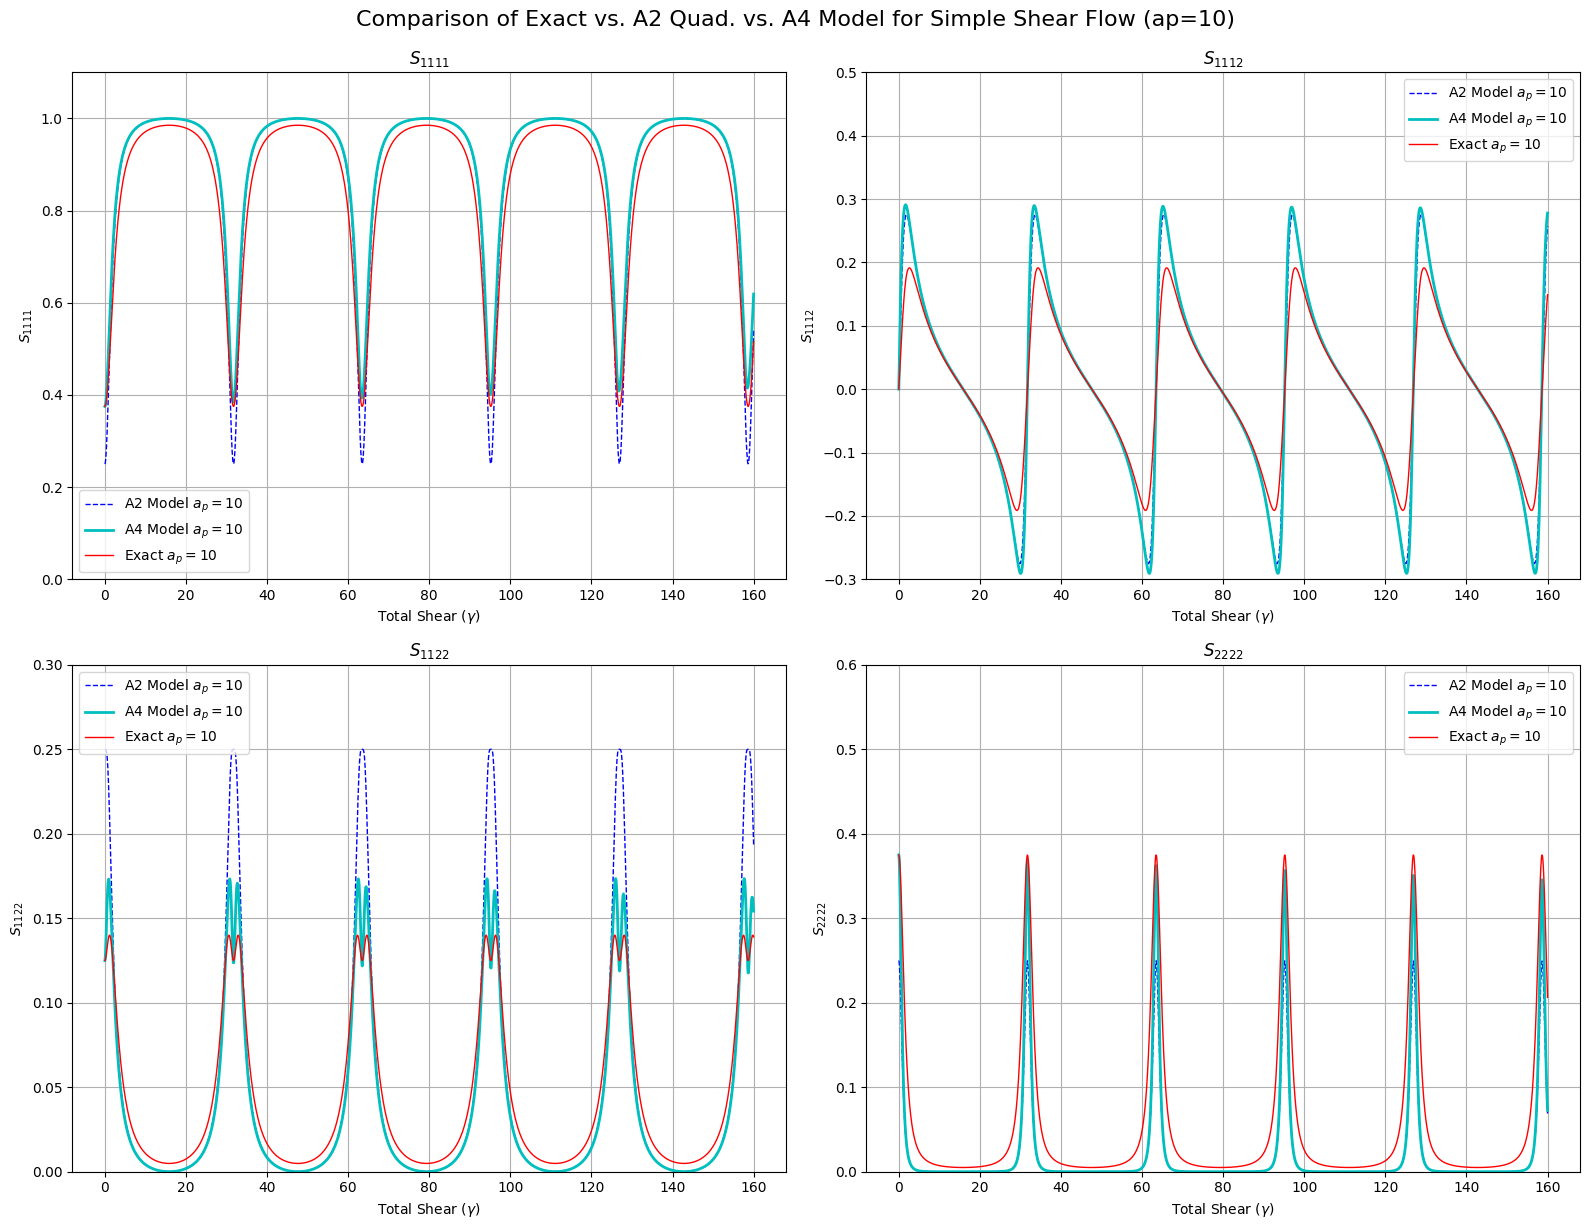


Starting Matplotlib plotting for Planar Elongational Flow...

--- Planar Elongational Flow: RMSE and MAPE Errors ---
  A2 Model $S_{1111}$ (ap=10): RMSE = 0.086731, MAPE = 9.22%
  A4 Model $S_{1111}$ (ap=10): RMSE = 0.134953, MAPE = 14.52%
  A2 Model $S_{1112}$ (ap=10): RMSE = 0.000000, MAPE = nan%
  A4 Model $S_{1112}$ (ap=10): RMSE = 0.000000, MAPE = nan%
  A2 Model $S_{1122}$ (ap=10): RMSE = 0.038829, MAPE = 77.80%
  A4 Model $S_{1122}$ (ap=10): RMSE = 0.031381, MAPE = 81.71%
  A2 Model $S_{2222}$ (ap=10): RMSE = 0.086739, MAPE = 94.17%
  A4 Model $S_{2222}$ (ap=10): RMSE = 0.076272, MAPE = 91.94%


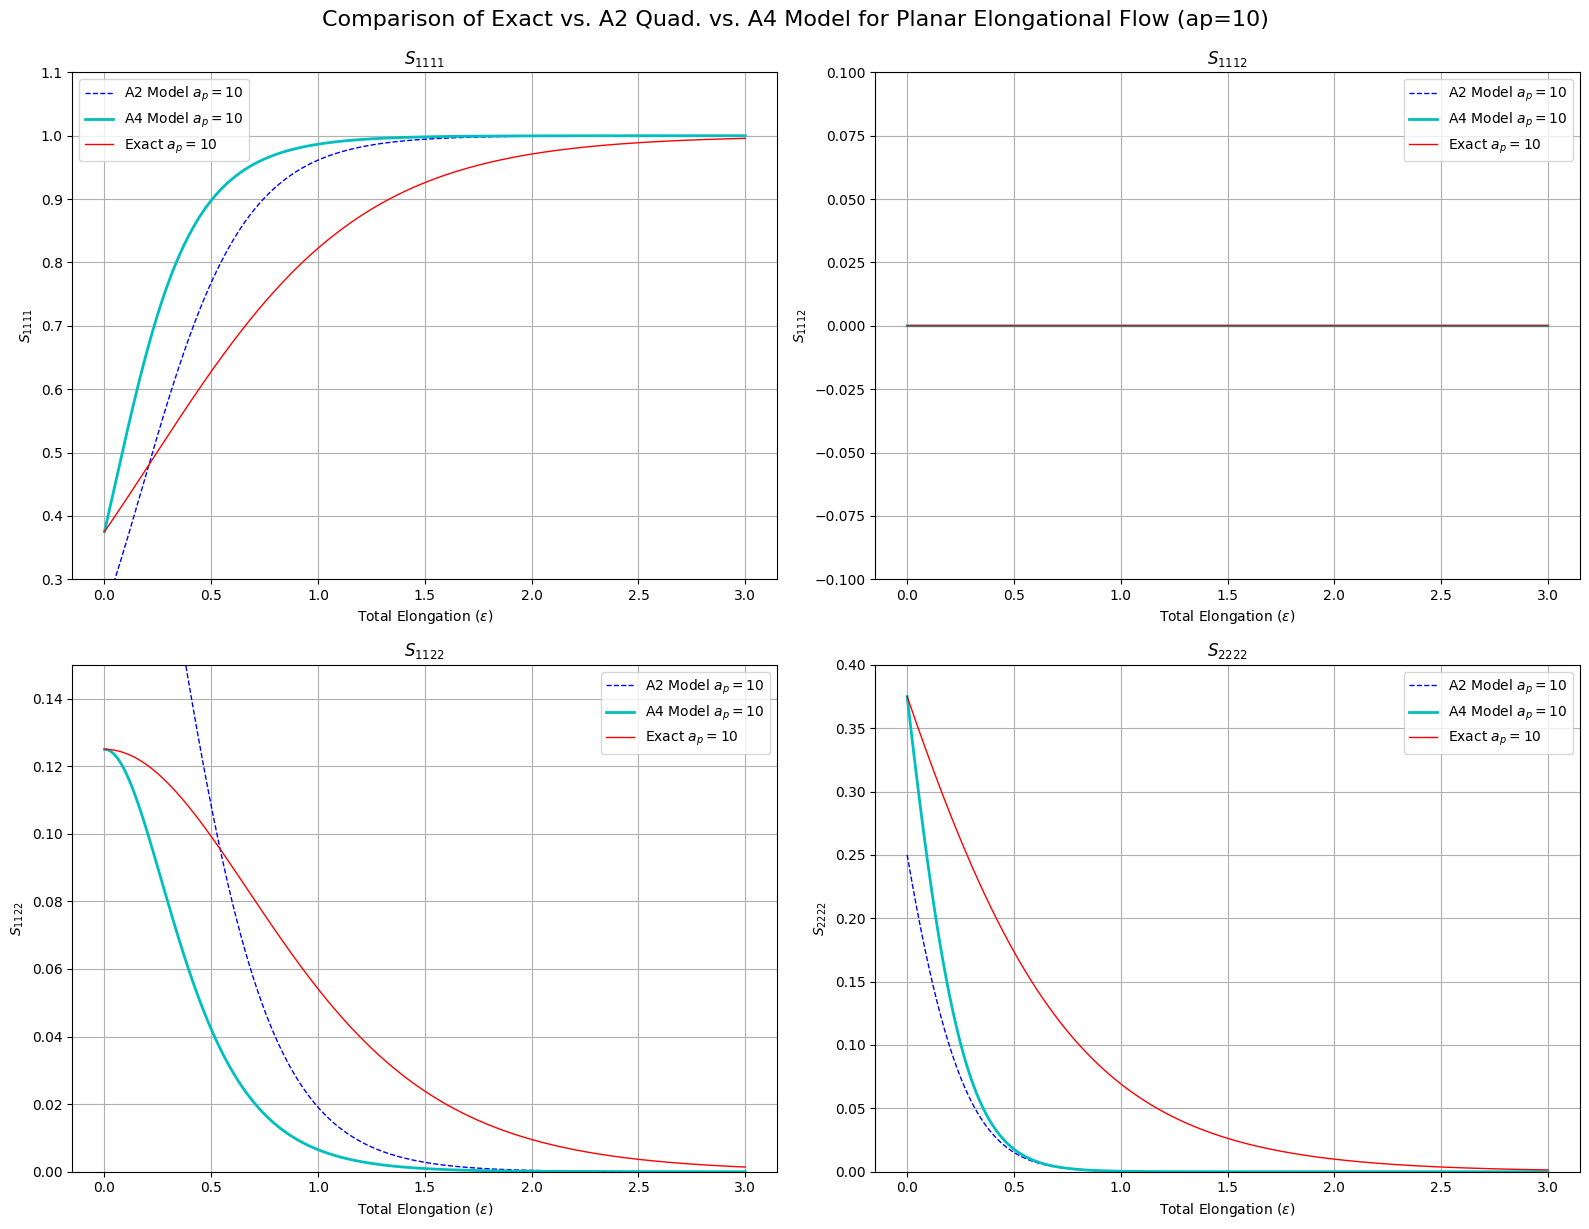


Data generated and saved. You can now open these VTK files in ParaView:
- orientation_tensors_shear_ap10_legacy_ascii.vtk
- orientation_tensors_elongation_ap10_legacy_ascii.vtk

Follow the instructions from the previous response to visualize tensors using glyphs.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import pandas as pd
import pyvista as pv

A_RANDOM_INITIAL_2D = np.array([[0.5, 0.0],
                                [0.0, 0.5]])

S_1111_RANDOM = 0.375
S_1112_RANDOM = 0.0
S_1122_RANDOM = 0.125
S_2222_RANDOM = 0.375
S_1222_RANDOM = 0.0

A4_RANDOM_INITIAL_FLAT = np.array([
    S_1111_RANDOM,
    S_1112_RANDOM,
    S_1122_RANDOM,
    S_1222_RANDOM,
    S_2222_RANDOM
])

EPSILON = 1e-10

def calculate_lambda(ap):
    if ap == 1:
        return 0.0
    else:
        return (ap**2 - 1) / (ap**2 + 1)

def get_L_simple_shear_2d(shear_rate):
    return np.array([[0, shear_rate],
                     [0, 0]])

def get_L_planar_elongational_2d(strain_rate):
    return np.array([[strain_rate, 0],
                     [0, -strain_rate]])

def quadratic_closure_A4_for_A2_model(A2_tensor):
    A = A2_tensor
    A4_closed = np.einsum('ik,jl->ijkl', A, A)
    return A4_closed

def jeffrey_ode_func_2d(A_flat, t, L_tensor, lambda_val):
    A = A_flat.reshape((2, 2))
    W = 0.5 * (L_tensor - L_tensor.T)
    D = 0.5 * (L_tensor + L_tensor.T)
    L_prime_tensor = W + lambda_val * D
    term_L_prime_S = np.einsum('im,mj->ij', L_prime_tensor, A) + \
                     np.einsum('jm,mi->ij', L_prime_tensor, A)
    closure_term = -2 * lambda_val * np.einsum('kl,kl->', D, A) * A
    dA_dt = term_L_prime_S + closure_term
    return dA_dt.flatten()

def A4_from_A2_quadratic_closure(A2_tensor):
    A11 = A2_tensor[0, 0]
    A12 = A2_tensor[0, 1]
    A22 = A2_tensor[1, 1]
    S1111_approx = A11 * A11
    S1112_approx = A11 * A12
    S1122_approx = A11 * A22
    S2222_approx = A22 * A22
    return S1111_approx, S1112_approx, S1122_approx, S2222_approx

def reconstruct_A4(A4_flat):
    A4 = np.zeros((2,2,2,2))
    A1111, A1112, A1122, A1222, A2222 = A4_flat
    A4[0,0,0,0] = A1111
    A4[0,0,0,1] = A1112; A4[0,0,1,0] = A1112; A4[0,1,0,0] = A1112; A4[1,0,0,0] = A1112
    A4[0,0,1,1] = A1122; A4[0,1,0,1] = A1122; A4[0,1,1,0] = A1122; A4[1,0,0,1] = A1122; A4[1,0,1,0] = A1122; A4[1,1,0,0] = A1122
    A4[1,1,1,1] = A2222
    A4[0,1,1,1] = A1222; A4[1,0,1,1] = A1222; A4[1,1,0,1] = A1222; A4[1,1,1,0] = A1222
    return A4

def get_A2_from_A4(A4_tensor):
    A2 = np.zeros((2,2))
    A2[0,0] = A4_tensor[0,0,0,0] + A4_tensor[0,1,1,0]
    A2[0,1] = A4_tensor[0,0,0,1] + A4_tensor[0,1,1,1]
    A2[1,0] = A4_tensor[1,0,0,0] + A4_tensor[1,1,1,0]
    A2[1,1] = A4_tensor[1,0,0,1] + A4_tensor[1,1,1,1]
    return A2

def jeffrey_ode_func_A4(A4_flat, t, L_tensor, lambda_val):
    A4 = reconstruct_A4(A4_flat)
    A2 = get_A2_from_A4(A4)
    W = 0.5 * (L_tensor - L_tensor.T)
    D = 0.5 * (L_tensor + L_tensor.T)
    L_prime_tensor = W + lambda_val * D
    term_hydrodynamic = np.einsum('im,mjkl->ijkl', L_prime_tensor, A4) + \
                        np.einsum('jm,imkl->ijkl', L_prime_tensor, A4) + \
                        np.einsum('km,ijml->ijkl', L_prime_tensor, A4) + \
                        np.einsum('lm,ijkm->ijkl', L_prime_tensor, A4)
    closure_term_A6 = -4 * lambda_val * np.einsum('rs,rs->', D, A2) * A4
    dA4_dt_tensor = term_hydrodynamic + closure_term_A6
    d_A4_dt_flat = np.array([
        dA4_dt_tensor[0,0,0,0],
        dA4_dt_tensor[0,0,0,1],
        dA4_dt_tensor[0,0,1,1],
        dA4_dt_tensor[0,1,1,1],
        dA4_dt_tensor[1,1,1,1]
    ])
    return d_A4_dt_flat

def calculate_shear_params_exact(gamma, ap):
    lam = calculate_lambda(ap)
    if np.isclose(lam, 1.0):
        wt_val = 0.0
    else:
        wt_val = (gamma / 2) * np.sqrt(1 - lam**2 + EPSILON)
    a1 = 1 - (2 * lam / (1 + lam)) * np.sin(wt_val)**2
    a2 = - (2 * lam / np.sqrt(1 - lam**2 + EPSILON)) * np.sin(2 * wt_val)
    a3 = 1 + (2 * lam / (1 - lam + EPSILON)) * np.sin(wt_val)**2
    return a1, a2, a3, wt_val

def S_ijkl_shear_exact(gamma, ap):
    if np.isclose(gamma, 0.0):
        return S_1111_RANDOM, S_1112_RANDOM, S_1122_RANDOM, S_1222_RANDOM, S_2222_RANDOM
    a1, a2, a3, wt_val = calculate_shear_params_exact(gamma, ap)
    if ap != 1 and np.isclose(np.sin(wt_val), 0.0, atol=1e-3):
         return S_1111_RANDOM, S_1112_RANDOM, S_1122_RANDOM, S_1222_RANDOM, S_2222_RANDOM
    common_denom_term = (a1 + a3)**2 - 4
    if np.isclose(common_denom_term, 0.0, atol=EPSILON):
        return S_1111_RANDOM, S_1112_RANDOM, S_1122_RANDOM, S_1222_RANDOM, S_2222_RANDOM
    S1111 = (a1 + a3 - 2)**2 * (4 + a1 + 5 * a3 + 2 * a3**2) / (2 * common_denom_term**2 + EPSILON)
    S1112 = - (a1 + a3 - 2)**2 * a2 * (1 + a3) / (2 * common_denom_term**2 + EPSILON)
    S1122 = (a1 + a3 - 2)**2 * (a1 + 2 * a1 * a3 + a3) / (2 * common_denom_term**2 + EPSILON)
    S1222 = - (a1 + a3 - 2)**2 * a2 * (1 + a3) / (2 * common_denom_term**2 + EPSILON)
    S2222 = (a1 + a3 - 2)**2 * (4 + 2 * a1**2 + 5 * a1 + a3) / (2 * common_denom_term**2 + EPSILON)
    return S1111, S1112, S1122, S1222, S2222

def calculate_elongation_params_exact(epsilon, ap):
    lam = calculate_lambda(ap)
    wt_val = lam * epsilon
    a1 = np.exp(-2 * wt_val)
    a2 = 0.0
    a3 = np.exp(2 * wt_val)
    return a1, a2, a3

def S_ijkl_elongation_exact(epsilon, ap):
    if np.isclose(epsilon, 0.0):
        return S_1111_RANDOM, S_1112_RANDOM, S_1122_RANDOM, S_1222_RANDOM, S_2222_RANDOM
    a1, a2, a3 = calculate_elongation_params_exact(epsilon, ap)
    common_denom_term = (a1 - a3)**2
    if np.isclose(common_denom_term, 0.0, atol=EPSILON):
        return S_1111_RANDOM, S_1112_RANDOM, S_1122_RANDOM, S_1222_RANDOM, S_2222_RANDOM
    S1111 = (a1 - 3 * a3 + 2 * a3**2) / (2 * common_denom_term + EPSILON)
    S1112 = 0.0
    S1122 = (a1 - 2 * a1 * a3 + a3) / (2 * common_denom_term + EPSILON)
    S1222 = 0.0
    S2222 = (2 * a1**2 - 3 * a1 + a3) / (2 * common_denom_term + EPSILON)
    return S1111, S1112, S1122, S1222, S2222

def calculate_mape(exact_values, predicted_values, threshold=1e-8):
    exact_np = np.array(exact_values)
    predicted_np = np.array(predicted_values)
    valid_indices = np.abs(exact_np) > threshold
    if np.sum(valid_indices) == 0:
        return np.nan
    percentage_errors = (np.abs(predicted_np[valid_indices] - exact_np[valid_indices]) / np.abs(exact_np[valid_indices])) * 100
    return np.mean(percentage_errors)

def save_tensor_data_to_vtk_legacy(flow_type, ap):
    if flow_type == 'shear':
        time_points = np.linspace(0, 160, 2000)
        shear_rate_val = 1.0
        L_flow = get_L_simple_shear_2d(shear_rate=shear_rate_val)
    elif flow_type == 'elongation':
        time_points = np.linspace(0, 3.0, 2000)
        strain_rate_val = 1.0
        L_flow = get_L_planar_elongational_2d(strain_rate=strain_rate_val)
    else:
        raise ValueError("Invalid flow_type. Choose 'shear' or 'elongation'.")
    lam = calculate_lambda(ap)
    sol_A4 = odeint(jeffrey_ode_func_A4, A4_RANDOM_INITIAL_FLAT, time_points, args=(L_flow, lam))
    A_ij_A4_model = []
    for a4_flat in sol_A4:
        a4_tensor = reconstruct_A4(a4_flat)
        a2_tensor = get_A2_from_A4(a4_tensor)
        A_ij_A4_model.append(a2_tensor.flatten())
    A_ij_A4_model = np.array(A_ij_A4_model)
    points = np.zeros((len(time_points), 3))
    points[:, 0] = time_points
    mesh = pv.PolyData(points)
    A_tensor_3x3_A4 = np.zeros((len(time_points), 9))
    A_tensor_3x3_A4[:, 0] = A_ij_A4_model[:, 0]
    A_tensor_3x3_A4[:, 1] = A_ij_A4_model[:, 3]
    A_tensor_3x3_A4[:, 3] = A_ij_A4_model[:, 1]
    A_tensor_3x3_A4[:, 6] = A_ij_A4_model[:, 2]
    mesh[f'A_ij_tensor'] = A_tensor_3x3_A4
    file_name = f'orientation_tensors_{flow_type}_ap{ap}_legacy_ascii.vtk'

    # This is the change to save as an ASCII file
    mesh.save(file_name, binary=False)

    print(f"Legacy VTK data saved to {file_name}")
    return file_name

def plot_comparison_shear_all_models():
    shear_rates = np.linspace(0, 160, 2000)
    aspect_ratios = [10]
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    component_titles = ['$S_{1111}$', '$S_{1112}$', '$S_{1122}$', '$S_{2222}$']
    y_limits_shear = {
        '$S_{1111}$': (0.0, 1.1),
        '$S_{1112}$': (-0.3, 0.5),
        '$S_{1122}$': (0.0, 0.3),
        '$S_{2222}$': (0.0, 0.6)
    }
    print("\n--- Simple Shear Flow: RMSE and MAPE Errors ---")
    for i, title in enumerate(component_titles):
        ax = axes[i]
        ax.set_title(title)
        ax.set_xlabel('Total Shear ($\gamma$)')
        ax.set_ylabel(title)
        ax.grid(True)
        ax.set_ylim(y_limits_shear[title])
        for ap in aspect_ratios:
            lam = calculate_lambda(ap)
            shear_rate_val = 1.0
            L_shear = get_L_simple_shear_2d(shear_rate=shear_rate_val)
            sol_quad_a2 = odeint(jeffrey_ode_func_2d, A_RANDOM_INITIAL_2D.flatten(), shear_rates, args=(L_shear, lam))
            ode_s_data_quad_a2 = []
            for j, gamma in enumerate(shear_rates):
                A_current = sol_quad_a2[j].reshape((2, 2))
                s1111, s1112, s1122, s2222 = A4_from_A2_quadratic_closure(A_current)
                if title == '$S_{1111}$': ode_s_data_quad_a2.append(s1111)
                elif title == '$S_{1112}$': ode_s_data_quad_a2.append(s1112)
                elif title == '$S_{1122}$': ode_s_data_quad_a2.append(s1122)
                elif title == '$S_{2222}$': ode_s_data_quad_a2.append(s2222)
            ax.plot(shear_rates, ode_s_data_quad_a2, 'b--', label=f'A2 Model $a_p={ap}$', linewidth=1)
            sol_A4 = odeint(jeffrey_ode_func_A4, A4_RANDOM_INITIAL_FLAT, shear_rates, args=(L_shear, lam))
            ode_s_data_A4 = []
            for j, gamma in enumerate(shear_rates):
                A4_current_flat = sol_A4[j]
                A4_current = reconstruct_A4(A4_current_flat)
                s1111 = A4_current[0,0,0,0]
                s1112 = A4_current[0,0,0,1]
                s1122 = A4_current[0,0,1,1]
                s2222 = A4_current[1,1,1,1]
                if title == '$S_{1111}$': ode_s_data_A4.append(s1111)
                elif title == '$S_{1112}$': ode_s_data_A4.append(s1112)
                elif title == '$S_{1122}$': ode_s_data_A4.append(s1122)
                elif title == '$S_{2222}$': ode_s_data_A4.append(s2222)
            ax.plot(shear_rates, ode_s_data_A4, 'c-', label=f'A4 Model $a_p={ap}$', linewidth=2)
            exact_s_data = []
            for gamma in shear_rates:
                s1111, s1112, s1122, s1222, s2222_exact = S_ijkl_shear_exact(gamma, ap)
                if title == '$S_{1111}$': exact_s_data.append(s1111)
                elif title == '$S_{1112}$': exact_s_data.append(s1112)
                elif title == '$S_{1122}$': exact_s_data.append(s1122)
                elif title == '$S_{2222}$': exact_s_data.append(s2222_exact)
            ax.plot(shear_rates, exact_s_data, 'r-', label=f'Exact $a_p={ap}$', linewidth=1)
            ode_data_np_quad_a2 = np.array(ode_s_data_quad_a2)
            ode_data_np_A4 = np.array(ode_s_data_A4)
            exact_data_np = np.array(exact_s_data)
            valid_indices_rmse = ~np.isnan(ode_data_np_quad_a2) & ~np.isnan(exact_data_np)
            if np.sum(valid_indices_rmse) > 0:
                rmse_quad_a2 = np.sqrt(np.mean((ode_data_np_quad_a2[valid_indices_rmse] - exact_data_np[valid_indices_rmse])**2))
            else:
                rmse_quad_a2 = np.nan
            mape_quad_a2 = calculate_mape(exact_data_np, ode_data_np_quad_a2)
            print(f"  A2 Model {title} (ap={ap}): RMSE = {rmse_quad_a2:.6f}, MAPE = {mape_quad_a2:.2f}%")
            valid_indices_rmse = ~np.isnan(ode_data_np_A4) & ~np.isnan(exact_data_np)
            if np.sum(valid_indices_rmse) > 0:
                rmse_A4 = np.sqrt(np.mean((ode_data_np_A4[valid_indices_rmse] - exact_data_np[valid_indices_rmse])**2))
            else:
                rmse_A4 = np.nan
            mape_A4 = calculate_mape(exact_data_np, ode_data_np_A4)
            print(f"  A4 Model {title} (ap={ap}): RMSE = {rmse_A4:.6f}, MAPE = {mape_A4:.2f}%")
        ax.legend()
    plt.tight_layout()
    plt.suptitle('Comparison of Exact vs. A2 Quad. vs. A4 Model for Simple Shear Flow (ap=10)', y=1.02, fontsize=16)
    plt.show()

def plot_comparison_elongational_all_models():
    elongation_rates = np.linspace(0, 3.0, 2000)
    aspect_ratios = [10]
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    component_titles = ['$S_{1111}$', '$S_{1112}$', '$S_{1122}$', '$S_{2222}$']
    y_limits_elongational = {
        '$S_{1111}$': (0.3, 1.1),
        '$S_{1112}$': (-0.1, 0.1),
        '$S_{1122}$': (0.0, 0.15),
        '$S_{2222}$': (0.0, 0.4)
    }
    print("\n--- Planar Elongational Flow: RMSE and MAPE Errors ---")
    for i, title in enumerate(component_titles):
        ax = axes[i]
        ax.set_title(title)
        ax.set_xlabel('Total Elongation ($\epsilon$)')
        ax.set_ylabel(title)
        ax.grid(True)
        ax.set_ylim(y_limits_elongational[title])
        for ap in aspect_ratios:
            lam = calculate_lambda(ap)
            strain_rate_val = 1.0
            L_elong = get_L_planar_elongational_2d(strain_rate=strain_rate_val)
            sol_quad_a2 = odeint(jeffrey_ode_func_2d, A_RANDOM_INITIAL_2D.flatten(), elongation_rates, args=(L_elong, lam))
            ode_s_data_quad_a2 = []
            for j, epsilon in enumerate(elongation_rates):
                A_current = sol_quad_a2[j].reshape((2, 2))
                s1111, s1112, s1122, s2222 = A4_from_A2_quadratic_closure(A_current)
                if title == '$S_{1111}$': ode_s_data_quad_a2.append(s1111)
                elif title == '$S_{1112}$': ode_s_data_quad_a2.append(s1112)
                elif title == '$S_{1122}$': ode_s_data_quad_a2.append(s1122)
                elif title == '$S_{2222}$': ode_s_data_quad_a2.append(s2222)
            ax.plot(elongation_rates, ode_s_data_quad_a2, 'b--', label=f'A2 Model $a_p={ap}$', linewidth=1)
            sol_A4 = odeint(jeffrey_ode_func_A4, A4_RANDOM_INITIAL_FLAT, elongation_rates, args=(L_elong, lam))
            ode_s_data_A4 = []
            for j, epsilon in enumerate(elongation_rates):
                A4_current_flat = sol_A4[j]
                A4_current = reconstruct_A4(A4_current_flat)
                s1111 = A4_current[0,0,0,0]
                s1112 = A4_current[0,0,0,1]
                s1122 = A4_current[0,0,1,1]
                s2222 = A4_current[1,1,1,1]
                if title == '$S_{1111}$': ode_s_data_A4.append(s1111)
                elif title == '$S_{1112}$': ode_s_data_A4.append(s1112)
                elif title == '$S_{1122}$': ode_s_data_A4.append(s1122)
                elif title == '$S_{2222}$': ode_s_data_A4.append(s2222)
            ax.plot(elongation_rates, ode_s_data_A4, 'c-', label=f'A4 Model $a_p={ap}$', linewidth=2)
            exact_s_data = []
            for epsilon in elongation_rates:
                s1111, s1112, s1122, s1222, s2222_exact = S_ijkl_elongation_exact(epsilon, ap)
                if title == '$S_{1111}$': exact_s_data.append(s1111)
                elif title == '$S_{1112}$': exact_s_data.append(s1112)
                elif title == '$S_{1122}$': exact_s_data.append(s1122)
                elif title == '$S_{2222}$': exact_s_data.append(s2222_exact)
            ax.plot(elongation_rates, exact_s_data, 'r-', label=f'Exact $a_p={ap}$', linewidth=1)
            ode_data_np_quad_a2 = np.array(ode_s_data_quad_a2)
            ode_data_np_A4 = np.array(ode_s_data_A4)
            exact_data_np = np.array(exact_s_data)
            valid_indices_rmse = ~np.isnan(ode_data_np_quad_a2) & ~np.isnan(exact_data_np)
            if np.sum(valid_indices_rmse) > 0:
                rmse_quad_a2 = np.sqrt(np.mean((ode_data_np_quad_a2[valid_indices_rmse] - exact_data_np[valid_indices_rmse])**2))
            else:
                rmse_quad_a2 = np.nan
            mape_quad_a2 = calculate_mape(exact_data_np, ode_data_np_quad_a2)
            print(f"  A2 Model {title} (ap={ap}): RMSE = {rmse_quad_a2:.6f}, MAPE = {mape_quad_a2:.2f}%")
            valid_indices_rmse = ~np.isnan(ode_data_np_A4) & ~np.isnan(exact_data_np)
            if np.sum(valid_indices_rmse) > 0:
                rmse_A4 = np.sqrt(np.mean((ode_data_np_A4[valid_indices_rmse] - exact_data_np[valid_indices_rmse])**2))
            else:
                rmse_A4 = np.nan
            mape_A4 = calculate_mape(exact_data_np, ode_data_np_A4)
            print(f"  A4 Model {title} (ap={ap}): RMSE = {rmse_A4:.6f}, MAPE = {mape_A4:.2f}%")
        ax.legend()
    plt.tight_layout()
    plt.suptitle('Comparison of Exact vs. A2 Quad. vs. A4 Model for Planar Elongational Flow (ap=10)', y=1.02, fontsize=16)
    plt.show()

if __name__ == "__main__":
    ap = 10
    print("Generating legacy VTK ASCII data files for ParaView...")
    shear_vtk = save_tensor_data_to_vtk_legacy('shear', ap)
    elongation_vtk = save_tensor_data_to_vtk_legacy('elongation', ap)

    print("\nStarting Matplotlib plotting for Simple Shear Flow...")
    plot_comparison_shear_all_models()
    print("\nStarting Matplotlib plotting for Planar Elongational Flow...")
    plot_comparison_elongational_all_models()

    print("\nData generated and saved. You can now open these VTK files in ParaView:")
    print(f"- {shear_vtk}")
    print(f"- {elongation_vtk}")
    print("\nFollow the instructions from the previous response to visualize tensors using glyphs.")

<>:219: SyntaxWarning: invalid escape sequence '\g'
<>:297: SyntaxWarning: invalid escape sequence '\e'
<>:219: SyntaxWarning: invalid escape sequence '\g'
<>:297: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipython-input-1187026731.py:219: SyntaxWarning: invalid escape sequence '\g'
  ax.set_xlabel('Total Shear ($\gamma$)')
/tmp/ipython-input-1187026731.py:297: SyntaxWarning: invalid escape sequence '\e'
  ax.set_xlabel('Total Elongation ($\epsilon$)')


Generating legacy VTK ASCII data files for ParaView...
Legacy VTK data saved to orientation_tensors_shear_ap10_Tensors.vtk
Legacy VTK data saved to orientation_tensors_elongation_ap10_Tensors.vtk

Starting Matplotlib plotting for Simple Shear Flow...

--- Simple Shear Flow: RMSE and MAPE Errors ---
  A2 Model $S_{1111}$ (ap=10): RMSE = 0.044438, MAPE = 5.19%
  A4 Model $S_{1111}$ (ap=10): RMSE = 0.047842, MAPE = 5.36%
  A2 Model $S_{1112}$ (ap=10): RMSE = 0.038560, MAPE = 19.19%
  A4 Model $S_{1112}$ (ap=10): RMSE = 0.047594, MAPE = 26.22%
  A2 Model $S_{1122}$ (ap=10): RMSE = 0.033160, MAPE = 55.02%
  A4 Model $S_{1122}$ (ap=10): RMSE = 0.011617, MAPE = 50.31%
  A2 Model $S_{2222}$ (ap=10): RMSE = 0.055274, MAPE = 91.58%
  A4 Model $S_{2222}$ (ap=10): RMSE = 0.045782, MAPE = 90.09%


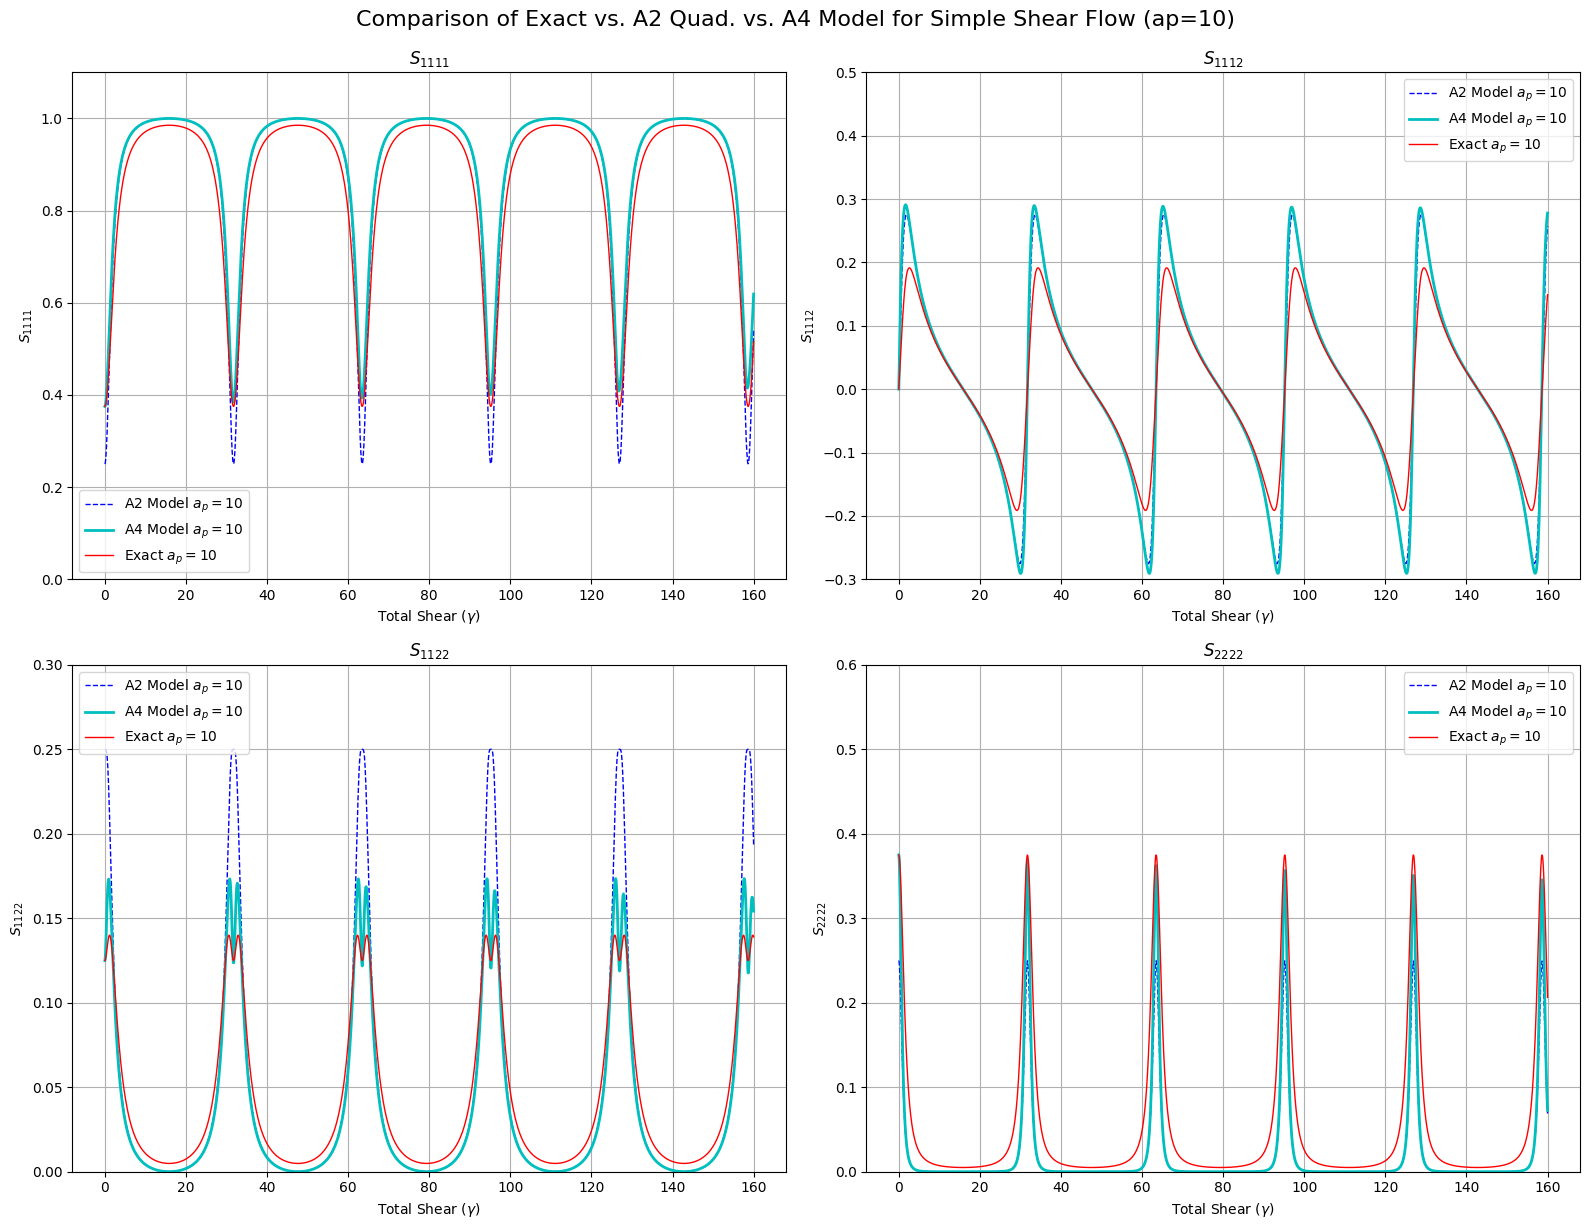


Starting Matplotlib plotting for Planar Elongational Flow...

--- Planar Elongational Flow: RMSE and MAPE Errors ---
  A2 Model $S_{1111}$ (ap=10): RMSE = 0.086731, MAPE = 9.22%
  A4 Model $S_{1111}$ (ap=10): RMSE = 0.134953, MAPE = 14.52%
  A2 Model $S_{1112}$ (ap=10): RMSE = 0.000000, MAPE = nan%
  A4 Model $S_{1112}$ (ap=10): RMSE = 0.000000, MAPE = nan%
  A2 Model $S_{1122}$ (ap=10): RMSE = 0.038829, MAPE = 77.80%
  A4 Model $S_{1122}$ (ap=10): RMSE = 0.031381, MAPE = 81.71%
  A2 Model $S_{2222}$ (ap=10): RMSE = 0.086739, MAPE = 94.17%
  A4 Model $S_{2222}$ (ap=10): RMSE = 0.076272, MAPE = 91.94%


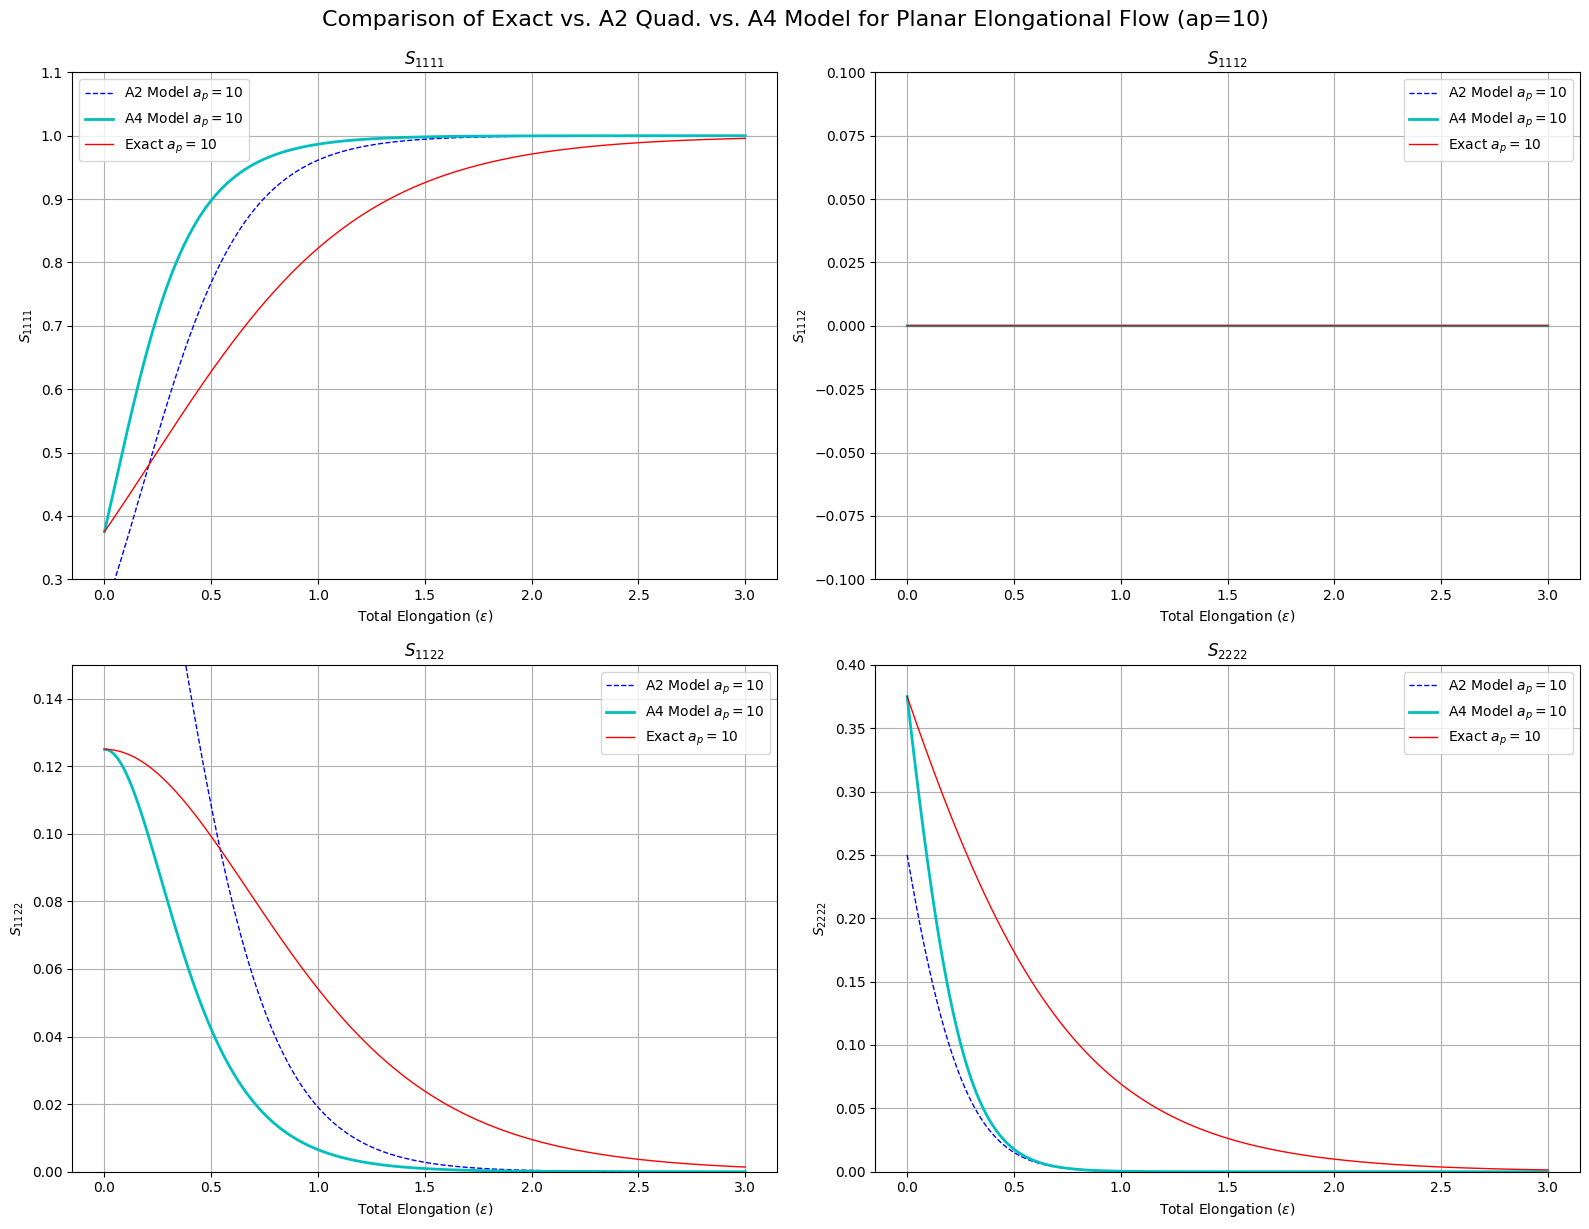


Data generated and saved. You can now open these VTK files in ParaView:
- orientation_tensors_shear_ap10_Tensors.vtk
- orientation_tensors_elongation_ap10_Tensors.vtk

Follow the instructions from the previous response to visualize tensors using glyphs.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import pandas as pd
import pyvista as pv

A_RANDOM_INITIAL_2D = np.array([[0.5, 0.0],
                                [0.0, 0.5]])

S_1111_RANDOM = 0.375
S_1112_RANDOM = 0.0
S_1122_RANDOM = 0.125
S_2222_RANDOM = 0.375
S_1222_RANDOM = 0.0

A4_RANDOM_INITIAL_FLAT = np.array([
    S_1111_RANDOM,
    S_1112_RANDOM,
    S_1122_RANDOM,
    S_1222_RANDOM,
    S_2222_RANDOM
])

EPSILON = 1e-10

def calculate_lambda(ap):
    if ap == 1:
        return 0.0
    else:
        return (ap**2 - 1) / (ap**2 + 1)

def get_L_simple_shear_2d(shear_rate):
    return np.array([[0, shear_rate],
                     [0, 0]])

def get_L_planar_elongational_2d(strain_rate):
    return np.array([[strain_rate, 0],
                     [0, -strain_rate]])

def quadratic_closure_A4_for_A2_model(A2_tensor):
    A = A2_tensor
    A4_closed = np.einsum('ik,jl->ijkl', A, A)
    return A4_closed

def jeffrey_ode_func_2d(A_flat, t, L_tensor, lambda_val):
    A = A_flat.reshape((2, 2))
    W = 0.5 * (L_tensor - L_tensor.T)
    D = 0.5 * (L_tensor + L_tensor.T)
    L_prime_tensor = W + lambda_val * D
    term_L_prime_S = np.einsum('im,mj->ij', L_prime_tensor, A) + \
                     np.einsum('jm,mi->ij', L_prime_tensor, A)
    closure_term = -2 * lambda_val * np.einsum('kl,kl->', D, A) * A
    dA_dt = term_L_prime_S + closure_term
    return dA_dt.flatten()

def A4_from_A2_quadratic_closure(A2_tensor):
    A11 = A2_tensor[0, 0]
    A12 = A2_tensor[0, 1]
    A22 = A2_tensor[1, 1]
    S1111_approx = A11 * A11
    S1112_approx = A11 * A12
    S1122_approx = A11 * A22
    S2222_approx = A22 * A22
    return S1111_approx, S1112_approx, S1122_approx, S2222_approx

def reconstruct_A4(A4_flat):
    A4 = np.zeros((2,2,2,2))
    A1111, A1112, A1122, A1222, A2222 = A4_flat
    A4[0,0,0,0] = A1111
    A4[0,0,0,1] = A1112; A4[0,0,1,0] = A1112; A4[0,1,0,0] = A1112; A4[1,0,0,0] = A1112
    A4[0,0,1,1] = A1122; A4[0,1,0,1] = A1122; A4[0,1,1,0] = A1122; A4[1,0,0,1] = A1122; A4[1,0,1,0] = A1122; A4[1,1,0,0] = A1122
    A4[1,1,1,1] = A2222
    A4[0,1,1,1] = A1222; A4[1,0,1,1] = A1222; A4[1,1,0,1] = A1222; A4[1,1,1,0] = A1222
    return A4

def get_A2_from_A4(A4_tensor):
    A2 = np.zeros((2,2))
    A2[0,0] = A4_tensor[0,0,0,0] + A4_tensor[0,1,1,0]
    A2[0,1] = A4_tensor[0,0,0,1] + A4_tensor[0,1,1,1]
    A2[1,0] = A4_tensor[1,0,0,0] + A4_tensor[1,1,1,0]
    A2[1,1] = A4_tensor[1,0,0,1] + A4_tensor[1,1,1,1]
    return A2

def jeffrey_ode_func_A4(A4_flat, t, L_tensor, lambda_val):
    A4 = reconstruct_A4(A4_flat)
    A2 = get_A2_from_A4(A4)
    W = 0.5 * (L_tensor - L_tensor.T)
    D = 0.5 * (L_tensor + L_tensor.T)
    L_prime_tensor = W + lambda_val * D
    term_hydrodynamic = np.einsum('im,mjkl->ijkl', L_prime_tensor, A4) + \
                        np.einsum('jm,imkl->ijkl', L_prime_tensor, A4) + \
                        np.einsum('km,ijml->ijkl', L_prime_tensor, A4) + \
                        np.einsum('lm,ijkm->ijkl', L_prime_tensor, A4)
    closure_term_A6 = -4 * lambda_val * np.einsum('rs,rs->', D, A2) * A4
    dA4_dt_tensor = term_hydrodynamic + closure_term_A6
    d_A4_dt_flat = np.array([
        dA4_dt_tensor[0,0,0,0],
        dA4_dt_tensor[0,0,0,1],
        dA4_dt_tensor[0,0,1,1],
        dA4_dt_tensor[0,1,1,1],
        dA4_dt_tensor[1,1,1,1]
    ])
    return d_A4_dt_flat

def calculate_shear_params_exact(gamma, ap):
    lam = calculate_lambda(ap)
    if np.isclose(lam, 1.0):
        wt_val = 0.0
    else:
        wt_val = (gamma / 2) * np.sqrt(1 - lam**2 + EPSILON)
    a1 = 1 - (2 * lam / (1 + lam)) * np.sin(wt_val)**2
    a2 = - (2 * lam / np.sqrt(1 - lam**2 + EPSILON)) * np.sin(2 * wt_val)
    a3 = 1 + (2 * lam / (1 - lam + EPSILON)) * np.sin(wt_val)**2
    return a1, a2, a3, wt_val

def S_ijkl_shear_exact(gamma, ap):
    if np.isclose(gamma, 0.0):
        return S_1111_RANDOM, S_1112_RANDOM, S_1122_RANDOM, S_1222_RANDOM, S_2222_RANDOM
    a1, a2, a3, wt_val = calculate_shear_params_exact(gamma, ap)
    if ap != 1 and np.isclose(np.sin(wt_val), 0.0, atol=1e-3):
         return S_1111_RANDOM, S_1112_RANDOM, S_1122_RANDOM, S_1222_RANDOM, S_2222_RANDOM
    common_denom_term = (a1 + a3)**2 - 4
    if np.isclose(common_denom_term, 0.0, atol=EPSILON):
        return S_1111_RANDOM, S_1112_RANDOM, S_1122_RANDOM, S_1222_RANDOM, S_2222_RANDOM
    S1111 = (a1 + a3 - 2)**2 * (4 + a1 + 5 * a3 + 2 * a3**2) / (2 * common_denom_term**2 + EPSILON)
    S1112 = - (a1 + a3 - 2)**2 * a2 * (1 + a3) / (2 * common_denom_term**2 + EPSILON)
    S1122 = (a1 + a3 - 2)**2 * (a1 + 2 * a1 * a3 + a3) / (2 * common_denom_term**2 + EPSILON)
    S1222 = - (a1 + a3 - 2)**2 * a2 * (1 + a3) / (2 * common_denom_term**2 + EPSILON)
    S2222 = (a1 + a3 - 2)**2 * (4 + 2 * a1**2 + 5 * a1 + a3) / (2 * common_denom_term**2 + EPSILON)
    return S1111, S1112, S1122, S1222, S2222

def calculate_elongation_params_exact(epsilon, ap):
    lam = calculate_lambda(ap)
    wt_val = lam * epsilon
    a1 = np.exp(-2 * wt_val)
    a2 = 0.0
    a3 = np.exp(2 * wt_val)
    return a1, a2, a3

def S_ijkl_elongation_exact(epsilon, ap):
    if np.isclose(epsilon, 0.0):
        return S_1111_RANDOM, S_1112_RANDOM, S_1122_RANDOM, S_1222_RANDOM, S_2222_RANDOM
    a1, a2, a3 = calculate_elongation_params_exact(epsilon, ap)
    common_denom_term = (a1 - a3)**2
    if np.isclose(common_denom_term, 0.0, atol=EPSILON):
        return S_1111_RANDOM, S_1112_RANDOM, S_1122_RANDOM, S_1222_RANDOM, S_2222_RANDOM
    S1111 = (a1 - 3 * a3 + 2 * a3**2) / (2 * common_denom_term + EPSILON)
    S1112 = 0.0
    S1122 = (a1 - 2 * a1 * a3 + a3) / (2 * common_denom_term + EPSILON)
    S1222 = 0.0
    S2222 = (2 * a1**2 - 3 * a1 + a3) / (2 * common_denom_term + EPSILON)
    return S1111, S1112, S1122, S1222, S2222

def calculate_mape(exact_values, predicted_values, threshold=1e-8):
    exact_np = np.array(exact_values)
    predicted_np = np.array(predicted_values)
    valid_indices = np.abs(exact_np) > threshold
    if np.sum(valid_indices) == 0:
        return np.nan
    percentage_errors = (np.abs(predicted_np[valid_indices] - exact_np[valid_indices]) / np.abs(exact_np[valid_indices])) * 100
    return np.mean(percentage_errors)

def save_tensor_data_to_vtk_explicit(flow_type, ap):
    if flow_type == 'shear':
        time_points = np.linspace(0, 160, 2000)
        shear_rate_val = 1.0
        L_flow = get_L_simple_shear_2d(shear_rate=shear_rate_val)
    elif flow_type == 'elongation':
        time_points = np.linspace(0, 3.0, 2000)
        strain_rate_val = 1.0
        L_flow = get_L_planar_elongational_2d(strain_rate=strain_rate_val)
    else:
        raise ValueError("Invalid flow_type. Choose 'shear' or 'elongation'.")
    lam = calculate_lambda(ap)
    sol_A4 = odeint(jeffrey_ode_func_A4, A4_RANDOM_INITIAL_FLAT, time_points, args=(L_flow, lam))
    A_ij_A4_model = []
    for a4_flat in sol_A4:
        a4_tensor = reconstruct_A4(a4_flat)
        a2_tensor = get_A2_from_A4(a4_tensor)
        A_ij_A4_model.append(a2_tensor)
    A_ij_A4_model = np.array(A_ij_A4_model)
    points = np.zeros((len(time_points), 3))
    points[:, 0] = time_points
    mesh = pv.PolyData(points)


    A_tensor_3x3_A4 = np.zeros((len(time_points), 3, 3))
    A_tensor_3x3_A4[:, 0, 0] = A_ij_A4_model[:, 0, 0]
    A_tensor_3x3_A4[:, 1, 1] = A_ij_A4_model[:, 1, 1]
    A_tensor_3x3_A4[:, 0, 1] = A_ij_A4_model[:, 0, 1]
    A_tensor_3x3_A4[:, 1, 0] = A_ij_A4_model[:, 1, 0]

    mesh['A_ij_Tensors'] = A_tensor_3x3_A4
    file_name = f'orientation_tensors_{flow_type}_ap{ap}_Tensors.vtk'


    mesh.save(file_name, binary=False)

    print(f"Legacy VTK data saved to {file_name}")
    return file_name

def plot_comparison_shear_all_models():
    shear_rates = np.linspace(0, 160, 2000)
    aspect_ratios = [10]
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    component_titles = ['$S_{1111}$', '$S_{1112}$', '$S_{1122}$', '$S_{2222}$']
    y_limits_shear = {
        '$S_{1111}$': (0.0, 1.1),
        '$S_{1112}$': (-0.3, 0.5),
        '$S_{1122}$': (0.0, 0.3),
        '$S_{2222}$': (0.0, 0.6)
    }
    print("\n--- Simple Shear Flow: RMSE and MAPE Errors ---")
    for i, title in enumerate(component_titles):
        ax = axes[i]
        ax.set_title(title)
        ax.set_xlabel('Total Shear ($\gamma$)')
        ax.set_ylabel(title)
        ax.grid(True)
        ax.set_ylim(y_limits_shear[title])
        for ap in aspect_ratios:
            lam = calculate_lambda(ap)
            shear_rate_val = 1.0
            L_shear = get_L_simple_shear_2d(shear_rate=shear_rate_val)
            sol_quad_a2 = odeint(jeffrey_ode_func_2d, A_RANDOM_INITIAL_2D.flatten(), shear_rates, args=(L_shear, lam))
            ode_s_data_quad_a2 = []
            for j, gamma in enumerate(shear_rates):
                A_current = sol_quad_a2[j].reshape((2, 2))
                s1111, s1112, s1122, s2222 = A4_from_A2_quadratic_closure(A_current)
                if title == '$S_{1111}$': ode_s_data_quad_a2.append(s1111)
                elif title == '$S_{1112}$': ode_s_data_quad_a2.append(s1112)
                elif title == '$S_{1122}$': ode_s_data_quad_a2.append(s1122)
                elif title == '$S_{2222}$': ode_s_data_quad_a2.append(s2222)
            ax.plot(shear_rates, ode_s_data_quad_a2, 'b--', label=f'A2 Model $a_p={ap}$', linewidth=1)
            sol_A4 = odeint(jeffrey_ode_func_A4, A4_RANDOM_INITIAL_FLAT, shear_rates, args=(L_shear, lam))
            ode_s_data_A4 = []
            for j, gamma in enumerate(shear_rates):
                A4_current_flat = sol_A4[j]
                A4_current = reconstruct_A4(A4_current_flat)
                s1111 = A4_current[0,0,0,0]
                s1112 = A4_current[0,0,0,1]
                s1122 = A4_current[0,0,1,1]
                s2222 = A4_current[1,1,1,1]
                if title == '$S_{1111}$': ode_s_data_A4.append(s1111)
                elif title == '$S_{1112}$': ode_s_data_A4.append(s1112)
                elif title == '$S_{1122}$': ode_s_data_A4.append(s1122)
                elif title == '$S_{2222}$': ode_s_data_A4.append(s2222)
            ax.plot(shear_rates, ode_s_data_A4, 'c-', label=f'A4 Model $a_p={ap}$', linewidth=2)
            exact_s_data = []
            for gamma in shear_rates:
                s1111, s1112, s1122, s1222, s2222_exact = S_ijkl_shear_exact(gamma, ap)
                if title == '$S_{1111}$': exact_s_data.append(s1111)
                elif title == '$S_{1112}$': exact_s_data.append(s1112)
                elif title == '$S_{1122}$': exact_s_data.append(s1122)
                elif title == '$S_{2222}$': exact_s_data.append(s2222_exact)
            ax.plot(shear_rates, exact_s_data, 'r-', label=f'Exact $a_p={ap}$', linewidth=1)
            ode_data_np_quad_a2 = np.array(ode_s_data_quad_a2)
            ode_data_np_A4 = np.array(ode_s_data_A4)
            exact_data_np = np.array(exact_s_data)
            valid_indices_rmse = ~np.isnan(ode_data_np_quad_a2) & ~np.isnan(exact_data_np)
            if np.sum(valid_indices_rmse) > 0:
                rmse_quad_a2 = np.sqrt(np.mean((ode_data_np_quad_a2[valid_indices_rmse] - exact_data_np[valid_indices_rmse])**2))
            else:
                rmse_quad_a2 = np.nan
            mape_quad_a2 = calculate_mape(exact_data_np, ode_data_np_quad_a2)
            print(f"  A2 Model {title} (ap={ap}): RMSE = {rmse_quad_a2:.6f}, MAPE = {mape_quad_a2:.2f}%")
            valid_indices_rmse = ~np.isnan(ode_data_np_A4) & ~np.isnan(exact_data_np)
            if np.sum(valid_indices_rmse) > 0:
                rmse_A4 = np.sqrt(np.mean((ode_data_np_A4[valid_indices_rmse] - exact_data_np[valid_indices_rmse])**2))
            else:
                rmse_A4 = np.nan
            mape_A4 = calculate_mape(exact_data_np, ode_data_np_A4)
            print(f"  A4 Model {title} (ap={ap}): RMSE = {rmse_A4:.6f}, MAPE = {mape_A4:.2f}%")
        ax.legend()
    plt.tight_layout()
    plt.suptitle('Comparison of Exact vs. A2 Quad. vs. A4 Model for Simple Shear Flow (ap=10)', y=1.02, fontsize=16)
    plt.show()

def plot_comparison_elongational_all_models():
    elongation_rates = np.linspace(0, 3.0, 2000)
    aspect_ratios = [10]
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    component_titles = ['$S_{1111}$', '$S_{1112}$', '$S_{1122}$', '$S_{2222}$']
    y_limits_elongational = {
        '$S_{1111}$': (0.3, 1.1),
        '$S_{1112}$': (-0.1, 0.1),
        '$S_{1122}$': (0.0, 0.15),
        '$S_{2222}$': (0.0, 0.4)
    }
    print("\n--- Planar Elongational Flow: RMSE and MAPE Errors ---")
    for i, title in enumerate(component_titles):
        ax = axes[i]
        ax.set_title(title)
        ax.set_xlabel('Total Elongation ($\epsilon$)')
        ax.set_ylabel(title)
        ax.grid(True)
        ax.set_ylim(y_limits_elongational[title])
        for ap in aspect_ratios:
            lam = calculate_lambda(ap)
            strain_rate_val = 1.0
            L_elong = get_L_planar_elongational_2d(strain_rate=strain_rate_val)
            sol_quad_a2 = odeint(jeffrey_ode_func_2d, A_RANDOM_INITIAL_2D.flatten(), elongation_rates, args=(L_elong, lam))
            ode_s_data_quad_a2 = []
            for j, epsilon in enumerate(elongation_rates):
                A_current = sol_quad_a2[j].reshape((2, 2))
                s1111, s1112, s1122, s2222 = A4_from_A2_quadratic_closure(A_current)
                if title == '$S_{1111}$': ode_s_data_quad_a2.append(s1111)
                elif title == '$S_{1112}$': ode_s_data_quad_a2.append(s1112)
                elif title == '$S_{1122}$': ode_s_data_quad_a2.append(s1122)
                elif title == '$S_{2222}$': ode_s_data_quad_a2.append(s2222)
            ax.plot(elongation_rates, ode_s_data_quad_a2, 'b--', label=f'A2 Model $a_p={ap}$', linewidth=1)
            sol_A4 = odeint(jeffrey_ode_func_A4, A4_RANDOM_INITIAL_FLAT, elongation_rates, args=(L_elong, lam))
            ode_s_data_A4 = []
            for j, epsilon in enumerate(elongation_rates):
                A4_current_flat = sol_A4[j]
                A4_current = reconstruct_A4(A4_current_flat)
                s1111 = A4_current[0,0,0,0]
                s1112 = A4_current[0,0,0,1]
                s1122 = A4_current[0,0,1,1]
                s2222 = A4_current[1,1,1,1]
                if title == '$S_{1111}$': ode_s_data_A4.append(s1111)
                elif title == '$S_{1112}$': ode_s_data_A4.append(s1112)
                elif title == '$S_{1122}$': ode_s_data_A4.append(s1122)
                elif title == '$S_{2222}$': ode_s_data_A4.append(s2222)
            ax.plot(elongation_rates, ode_s_data_A4, 'c-', label=f'A4 Model $a_p={ap}$', linewidth=2)
            exact_s_data = []
            for epsilon in elongation_rates:
                s1111, s1112, s1122, s1222, s2222_exact = S_ijkl_elongation_exact(epsilon, ap)
                if title == '$S_{1111}$': exact_s_data.append(s1111)
                elif title == '$S_{1112}$': exact_s_data.append(s1112)
                elif title == '$S_{1122}$': exact_s_data.append(s1122)
                elif title == '$S_{2222}$': exact_s_data.append(s2222_exact)
            ax.plot(elongation_rates, exact_s_data, 'r-', label=f'Exact $a_p={ap}$', linewidth=1)
            ode_data_np_quad_a2 = np.array(ode_s_data_quad_a2)
            ode_data_np_A4 = np.array(ode_s_data_A4)
            exact_data_np = np.array(exact_s_data)
            valid_indices_rmse = ~np.isnan(ode_data_np_quad_a2) & ~np.isnan(exact_data_np)
            if np.sum(valid_indices_rmse) > 0:
                rmse_quad_a2 = np.sqrt(np.mean((ode_data_np_quad_a2[valid_indices_rmse] - exact_data_np[valid_indices_rmse])**2))
            else:
                rmse_quad_a2 = np.nan
            mape_quad_a2 = calculate_mape(exact_data_np, ode_data_np_quad_a2)
            print(f"  A2 Model {title} (ap={ap}): RMSE = {rmse_quad_a2:.6f}, MAPE = {mape_quad_a2:.2f}%")
            valid_indices_rmse = ~np.isnan(ode_data_np_A4) & ~np.isnan(exact_data_np)
            if np.sum(valid_indices_rmse) > 0:
                rmse_A4 = np.sqrt(np.mean((ode_data_np_A4[valid_indices_rmse] - exact_data_np[valid_indices_rmse])**2))
            else:
                rmse_A4 = np.nan
            mape_A4 = calculate_mape(exact_data_np, ode_data_np_A4)
            print(f"  A4 Model {title} (ap={ap}): RMSE = {rmse_A4:.6f}, MAPE = {mape_A4:.2f}%")
        ax.legend()
    plt.tight_layout()
    plt.suptitle('Comparison of Exact vs. A2 Quad. vs. A4 Model for Planar Elongational Flow (ap=10)', y=1.02, fontsize=16)
    plt.show()

if __name__ == "__main__":
    ap = 10
    print("Generating legacy VTK ASCII data files for ParaView...")
    shear_vtk = save_tensor_data_to_vtk_explicit('shear', ap)
    elongation_vtk = save_tensor_data_to_vtk_explicit('elongation', ap)

    print("\nStarting Matplotlib plotting for Simple Shear Flow...")
    plot_comparison_shear_all_models()
    print("\nStarting Matplotlib plotting for Planar Elongational Flow...")
    plot_comparison_elongational_all_models()

    print("\nData generated and saved. You can now open these VTK files in ParaView:")
    print(f"- {shear_vtk}")
    print(f"- {elongation_vtk}")
    print("\nFollow the instructions from the previous response to visualize tensors using glyphs.")

In [ ]:
import numpy as np
from scipy.integrate import odeint
import pyvista as pv


A_RANDOM_INITIAL_2D = np.array([[0.5, 0.0],
                                [0.0, 0.5]])

S_1111_RANDOM = 0.375
S_1112_RANDOM = 0.0
S_1122_RANDOM = 0.125
S_2222_RANDOM = 0.375
S_1222_RANDOM = 0.0

A4_RANDOM_INITIAL_FLAT = np.array([
    S_1111_RANDOM,
    S_1112_RANDOM,
    S_1122_RANDOM,
    S_1222_RANDOM,
    S_2222_RANDOM
])

EPSILON = 1e-10



def calculate_lambda(ap):
    if ap == 1:
        return 0.0
    else:
        return (ap**2 - 1) / (ap**2 + 1)

def get_L_simple_shear_2d(shear_rate):
    return np.array([[0, shear_rate],
                     [0, 0]])

def get_L_planar_elongational_2d(strain_rate):
    return np.array([[strain_rate, 0],
                     [0, -strain_rate]])

def reconstruct_A4(A4_flat):
    A4 = np.zeros((2,2,2,2))
    A1111, A1112, A1122, A1222, A2222 = A4_flat
    A4[0,0,0,0] = A1111
    A4[0,0,0,1] = A1112; A4[0,0,1,0] = A1112; A4[0,1,0,0] = A1112; A4[1,0,0,0] = A1112
    A4[0,0,1,1] = A1122; A4[0,1,0,1] = A1122; A4[0,1,1,0] = A1122; A4[1,0,0,1] = A1122; A4[1,0,1,0] = A1122; A4[1,1,0,0] = A1122
    A4[1,1,1,1] = A2222
    A4[0,1,1,1] = A1222; A4[1,0,1,1] = A1222; A4[1,1,0,1] = A1222; A4[1,1,1,0] = A1222
    return A4

def get_A2_from_A4(A4_tensor):
    A2 = np.zeros((2,2))
    A2[0,0] = A4_tensor[0,0,0,0] + A4_tensor[0,1,1,0]
    A2[0,1] = A4_tensor[0,0,0,1] + A4_tensor[0,1,1,1]
    A2[1,0] = A4_tensor[1,0,0,0] + A4_tensor[1,1,1,0]
    A2[1,1] = A4_tensor[1,0,0,1] + A4_tensor[1,1,1,1]
    return A2

def jeffrey_ode_func_A4(A4_flat, t, L_tensor, lambda_val):
    A4 = reconstruct_A4(A4_flat)
    A2 = get_A2_from_A4(A4)
    W = 0.5 * (L_tensor - L_tensor.T)
    D = 0.5 * (L_tensor + L_tensor.T)
    L_prime_tensor = W + lambda_val * D
    term_hydrodynamic = np.einsum('im,mjkl->ijkl', L_prime_tensor, A4) + \
                        np.einsum('jm,imkl->ijkl', L_prime_tensor, A4) + \
                        np.einsum('km,ijml->ijkl', L_prime_tensor, A4) + \
                        np.einsum('lm,ijkm->ijkl', L_prime_tensor, A4)
    closure_term_A6 = -4 * lambda_val * np.einsum('rs,rs->', D, A2) * A4
    dA4_dt_tensor = term_hydrodynamic + closure_term_A6
    d_A4_dt_flat = np.array([
        dA4_dt_tensor[0,0,0,0],
        dA4_dt_tensor[0,0,0,1],
        dA4_dt_tensor[0,0,1,1],
        dA4_dt_tensor[0,1,1,1],
        dA4_dt_tensor[1,1,1,1]
    ])
    return d_A4_dt_flat


def generate_tensor_mesh_file(flow_type, ap):

    if flow_type == 'shear':
        time_points = np.linspace(0, 160, 2000)
        shear_rate_val = 1.0
        L_flow = get_L_simple_shear_2d(shear_rate=shear_rate_val)
    elif flow_type == 'elongation':
        time_points = np.linspace(0, 3.0, 2000)
        strain_rate_val = 1.0
        L_flow = get_L_planar_elongational_2d(strain_rate=strain_rate_val)
    else:
        raise ValueError("Invalid flow_type. Choose 'shear' or 'elongation'.")

    lam = calculate_lambda(ap)
    sol_A4 = odeint(jeffrey_ode_func_A4, A4_RANDOM_INITIAL_FLAT, time_points, args=(L_flow, lam))


    A_ij_A4_model = []
    for a4_flat in sol_A4:
        a4_tensor = reconstruct_A4(a4_flat)
        a2_tensor = get_A2_from_A4(a4_tensor)
        A_ij_A4_model.append(a2_tensor)
    A_ij_A4_model = np.array(A_ij_A4_model)

    x_coords = time_points
    y_coords = np.array([0.0])
    z_coords = np.array([0.0])
    mesh = pv.RectilinearGrid(x_coords, y_coords, z_coords)

    A_tensor_3x3 = np.zeros((len(time_points), 3, 3))
    A_tensor_3x3[:, 0, 0] = A_ij_A4_model[:, 0, 0]
    A_tensor_3x3[:, 1, 1] = A_ij_A4_model[:, 1, 1]
    A_tensor_3x3[:, 0, 1] = A_ij_A4_model[:, 0, 1]
    A_tensor_3x3[:, 1, 0] = A_ij_A4_model[:, 1, 0]

    mesh['A_ij_Tensors'] = A_tensor_3x3

    file_name = f'orientation_tensors_{flow_type}_ap{ap}_Tensors.vtk'
    mesh.save(file_name, binary=False)

    print(f"VTK mesh file saved successfully: {file_name}")
    return file_name

if __name__ == "__main__":

    aspect_ratio = 10


    print("Generating tensor data for Simple Shear Flow...")
    shear_vtk_file = generate_tensor_mesh_file('shear', aspect_ratio)

    print("\nGenerating tensor data for Planar Elongational Flow...")
    elongation_vtk_file = generate_tensor_mesh_file('elongation', aspect_ratio)

    print("\nFile generation complete. You can now open these files in ParaView.")
    print(f"Generated Files:\n- {shear_vtk_file}\n- {elongation_vtk_file}")

Generating tensor data for Simple Shear Flow...
VTK mesh file saved successfully: orientation_tensors_shear_ap10_Tensors.vtk

Generating tensor data for Planar Elongational Flow...
VTK mesh file saved successfully: orientation_tensors_elongation_ap10_Tensors.vtk

File generation complete. You can now open these files in ParaView.
Generated Files:
- orientation_tensors_shear_ap10_Tensors.vtk
- orientation_tensors_elongation_ap10_Tensors.vtk


In [ ]:
# This script generates a simple VTK file (.vtk) with a set of points.
# This file can be used as input for other VTK-based scripts.

import vtk
import random

def generate_sample_vtk_file(filename="points.vtk", num_points=100):
    """
    Generates a legacy VTK file with random points.

    Args:
        filename (str): The name of the output .vtk file.
        num_points (int): The number of random points to generate.
    """
    print(f"Generating {num_points} random points...")

    # Create a vtkPoints object to hold the point coordinates
    points = vtk.vtkPoints()

    # Generate random points and add them to the points object
    for i in range(num_points):
        x = random.uniform(-10.0, 10.0)
        y = random.uniform(-10.0, 10.0)
        z = random.uniform(-10.0, 10.0)
        points.InsertNextPoint(x, y, z)

    print(f"Successfully generated {points.GetNumberOfPoints()} points.")

    # Create a vtkPolyData object to represent the dataset
    poly_data = vtk.vtkPolyData()
    poly_data.SetPoints(points)

    # Write the polydata to a legacy .vtk file
    print(f"Writing data to legacy VTK file: {filename}")
    writer = vtk.vtkPolyDataWriter()
    writer.SetFileName(filename)
    writer.SetInputData(poly_data)
    writer.Write()

    print("File generation complete!")
    print(f"You can now use '{filename}' as the input file for your other script.")

if __name__ == "__main__":
    generate_sample_vtk_file()


Generating 100 random points...
Successfully generated 100 points.
Writing data to legacy VTK file: points.vtk
File generation complete!
You can now use 'points.vtk' as the input file for your other script.


In [ ]:
# This script converts a VTK PolyData or legacy VTK file into an Unstructured Grid (.vtu)
# and adds a sample tensor field to each point. The output is in ASCII format.

import vtk
import os.path
import random

# --- File Paths ---
# IMPORTANT: Change this to your actual input file name.
# Make sure the file is in the same directory as this script.
input_vtk_file = "orientation_tensors_elongation_ap10.vtk"
output_vtu_file = "output_tensors.vtu"

# --- Step 1: Read the existing VTK file, using the correct reader for its format ---
print(f"Reading VTK file: {input_vtk_file}")

# Determine the file type based on its extension
extension = os.path.splitext(input_vtk_file)[1].lower()
reader = None

if extension == '.vtp':
    reader = vtk.vtkXMLPolyDataReader()
elif extension == '.vtk':
    reader = vtk.vtkDataSetReader()
else:
    print("Error: Unsupported file type. Please use a .vtp or .vtk file.")
    exit()

reader.SetFileName(input_vtk_file)
reader.Update()

poly_data = reader.GetOutput()
if not poly_data or poly_data.GetNumberOfPoints() == 0:
    print("Error: Could not read the input file or the file is empty.")
    exit()
else:
    print(f"Successfully read {poly_data.GetNumberOfPoints()} points.")

# --- Step 2: Generate a volumetric mesh from the points ---
# We'll use the Delaunay3D filter to create a tetrahedral mesh.
print("Generating a 3D tetrahedral mesh using Delaunay triangulation...")
delaunay = vtk.vtkDelaunay3D()
delaunay.SetInputData(poly_data)
delaunay.Update()

unstructured_grid = delaunay.GetOutput()
print(f"Generated an Unstructured Grid with {unstructured_grid.GetNumberOfPoints()} points and {unstructured_grid.GetNumberOfCells()} cells.")

# --- Step 3: Create and add the tensor data to the mesh ---
# VisIt and other visualization tools can use this data to render glyphs.
print("Creating sample tensor data for visualization...")
tensors = vtk.vtkDoubleArray()
tensors.SetName("EllipsoidTensors")
tensors.SetNumberOfComponents(9) # 3x3 tensor
tensors.SetNumberOfTuples(unstructured_grid.GetNumberOfPoints())

# Generate a sample tensor for each point.
# You will need to replace this section with your actual tensor data.
for i in range(unstructured_grid.GetNumberOfPoints()):
    x, y, z = unstructured_grid.GetPoint(i)

    # Example: Varying eigenvalues based on point coordinates.
    # This creates a diagonal tensor with components changing in space.
    # The components represent the squared lengths of the principal axes.
    t_xx = 1.0 + x*0.5
    t_yy = 1.0 + y*0.5
    t_zz = 1.0 + z*0.5

    # Set the 3x3 tensor values (row-major order).
    tensor_data = [t_xx, 0, 0,
                   0, t_yy, 0,
                   0, 0, t_zz]
    tensors.SetTuple(i, tensor_data)

# Add the tensor array to the PointData of the Unstructured Grid.
unstructured_grid.GetPointData().AddArray(tensors)

# --- Step 4: Write the new Unstructured Grid to a file ---
print(f"Writing Unstructured Grid with tensor data to file: {output_vtu_file}")
writer = vtk.vtkXMLUnstructuredGridWriter()
writer.SetFileName(output_vtu_file)

# IMPORTANT: Set the output file type to ASCII.
writer.SetDataModeToAscii()

writer.SetInputData(unstructured_grid)
writer.Update()

print("Conversion and data addition complete!")
print(f"You can now open '{output_vtu_file}' in VisIt and select 'EllipsoidTensors' to visualize.")


Reading VTK file: orientation_tensors_elongation_ap10.vtk
Successfully read 2000 points.
Generating a 3D tetrahedral mesh using Delaunay triangulation...
Generated an Unstructured Grid with 2000 points and 0 cells.
Creating sample tensor data for visualization...
Writing Unstructured Grid with tensor data to file: output_tensors.vtu
Conversion and data addition complete!
You can now open 'output_tensors.vtu' in VisIt and select 'EllipsoidTensors' to visualize.


<>:241: SyntaxWarning: invalid escape sequence '\g'
<>:319: SyntaxWarning: invalid escape sequence '\e'
<>:241: SyntaxWarning: invalid escape sequence '\g'
<>:319: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipython-input-1851177352.py:241: SyntaxWarning: invalid escape sequence '\g'
  ax.set_xlabel('Total Shear ($\gamma$)')
/tmp/ipython-input-1851177352.py:319: SyntaxWarning: invalid escape sequence '\e'
  ax.set_xlabel('Total Elongation ($\epsilon$)')


Generating PolyData VTK ASCII data files...
PolyData VTK data saved to orientation_tensors_shear_ap10.vtk
PolyData VTK data saved to orientation_tensors_elongation_ap10.vtk

Starting Matplotlib plotting for Simple Shear Flow...

--- Simple Shear Flow: RMSE and MAPE Errors ---
  A2 Model $S_{1111}$ (ap=10): RMSE = 0.044438, MAPE = 5.19%
  A4 Model $S_{1111}$ (ap=10): RMSE = 0.047842, MAPE = 5.36%
  A2 Model $S_{1112}$ (ap=10): RMSE = 0.038560, MAPE = 19.19%
  A4 Model $S_{1112}$ (ap=10): RMSE = 0.047594, MAPE = 26.22%
  A2 Model $S_{1122}$ (ap=10): RMSE = 0.033160, MAPE = 55.02%
  A4 Model $S_{1122}$ (ap=10): RMSE = 0.011617, MAPE = 50.31%
  A2 Model $S_{2222}$ (ap=10): RMSE = 0.055274, MAPE = 91.58%
  A4 Model $S_{2222}$ (ap=10): RMSE = 0.045782, MAPE = 90.09%


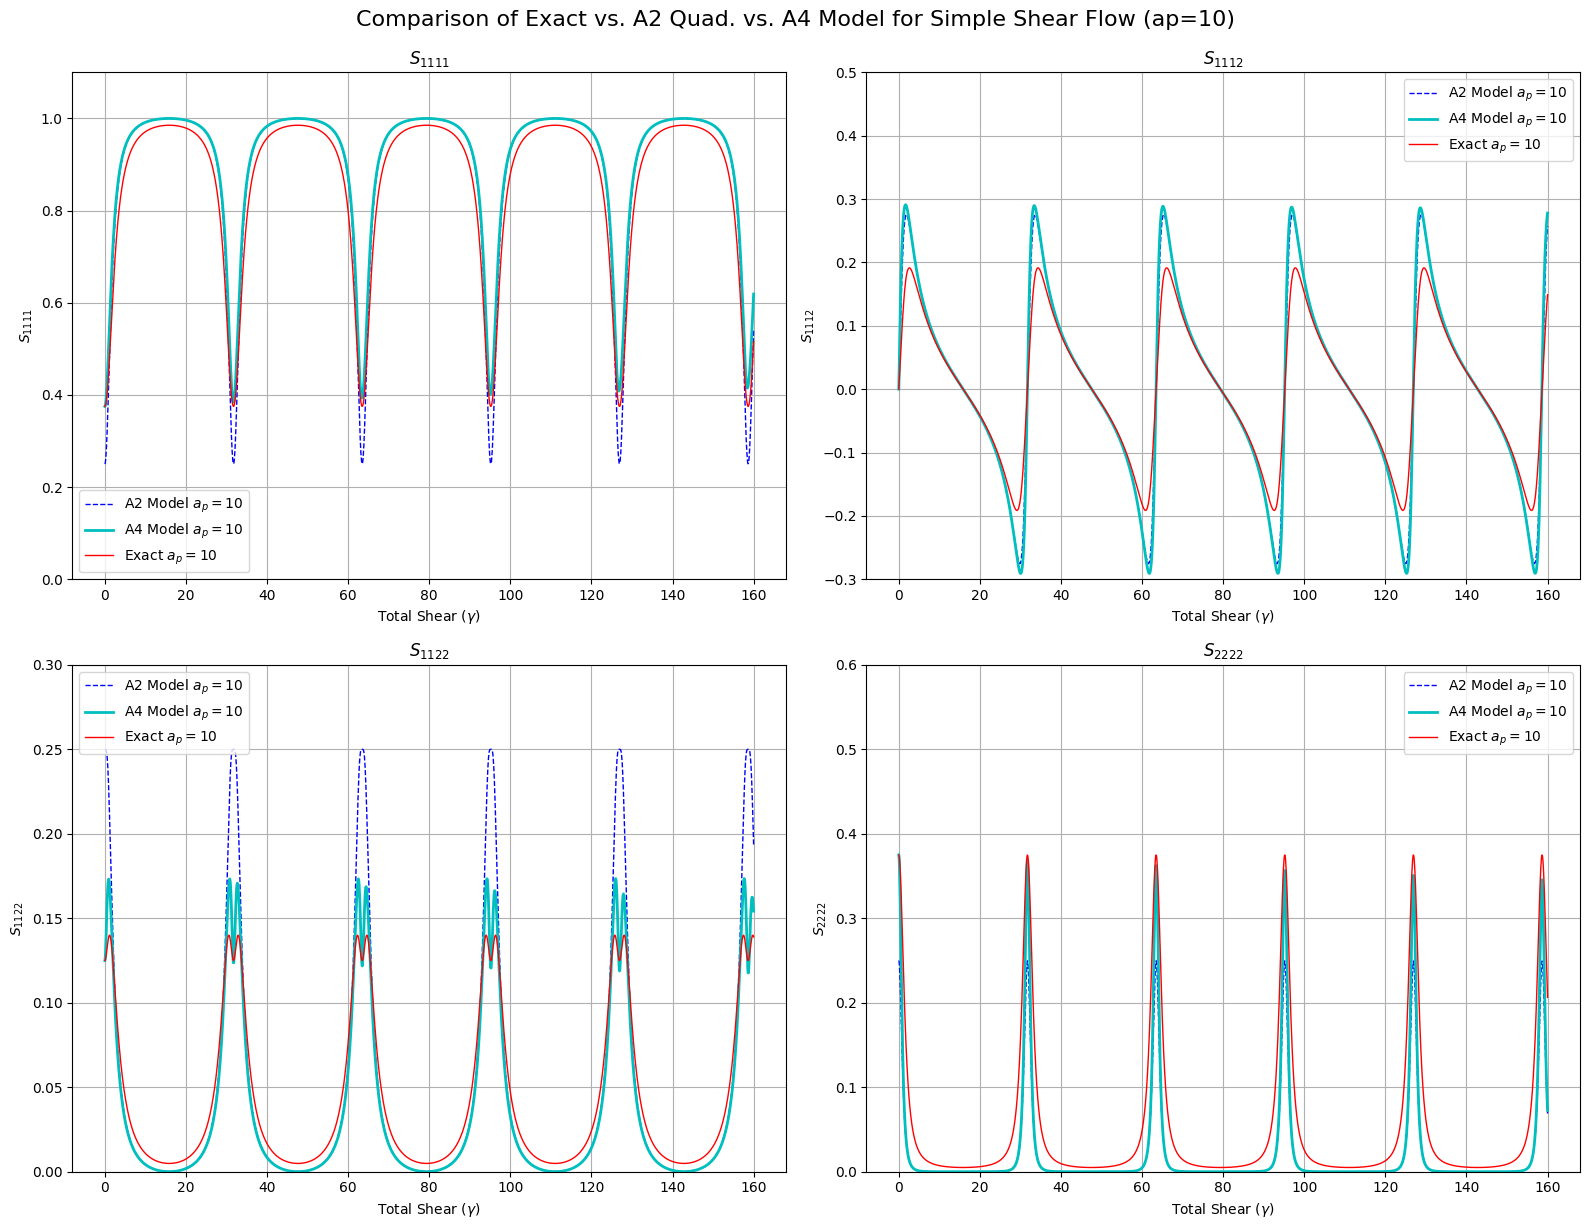


Starting Matplotlib plotting for Planar Elongational Flow...

--- Planar Elongational Flow: RMSE and MAPE Errors ---
  A2 Model $S_{1111}$ (ap=10): RMSE = 0.086731, MAPE = 9.22%
  A4 Model $S_{1111}$ (ap=10): RMSE = 0.134953, MAPE = 14.52%
  A2 Model $S_{1112}$ (ap=10): RMSE = 0.000000, MAPE = nan%
  A4 Model $S_{1112}$ (ap=10): RMSE = 0.000000, MAPE = nan%
  A2 Model $S_{1122}$ (ap=10): RMSE = 0.038829, MAPE = 77.80%
  A4 Model $S_{1122}$ (ap=10): RMSE = 0.031381, MAPE = 81.71%
  A2 Model $S_{2222}$ (ap=10): RMSE = 0.086739, MAPE = 94.17%
  A4 Model $S_{2222}$ (ap=10): RMSE = 0.076272, MAPE = 91.94%


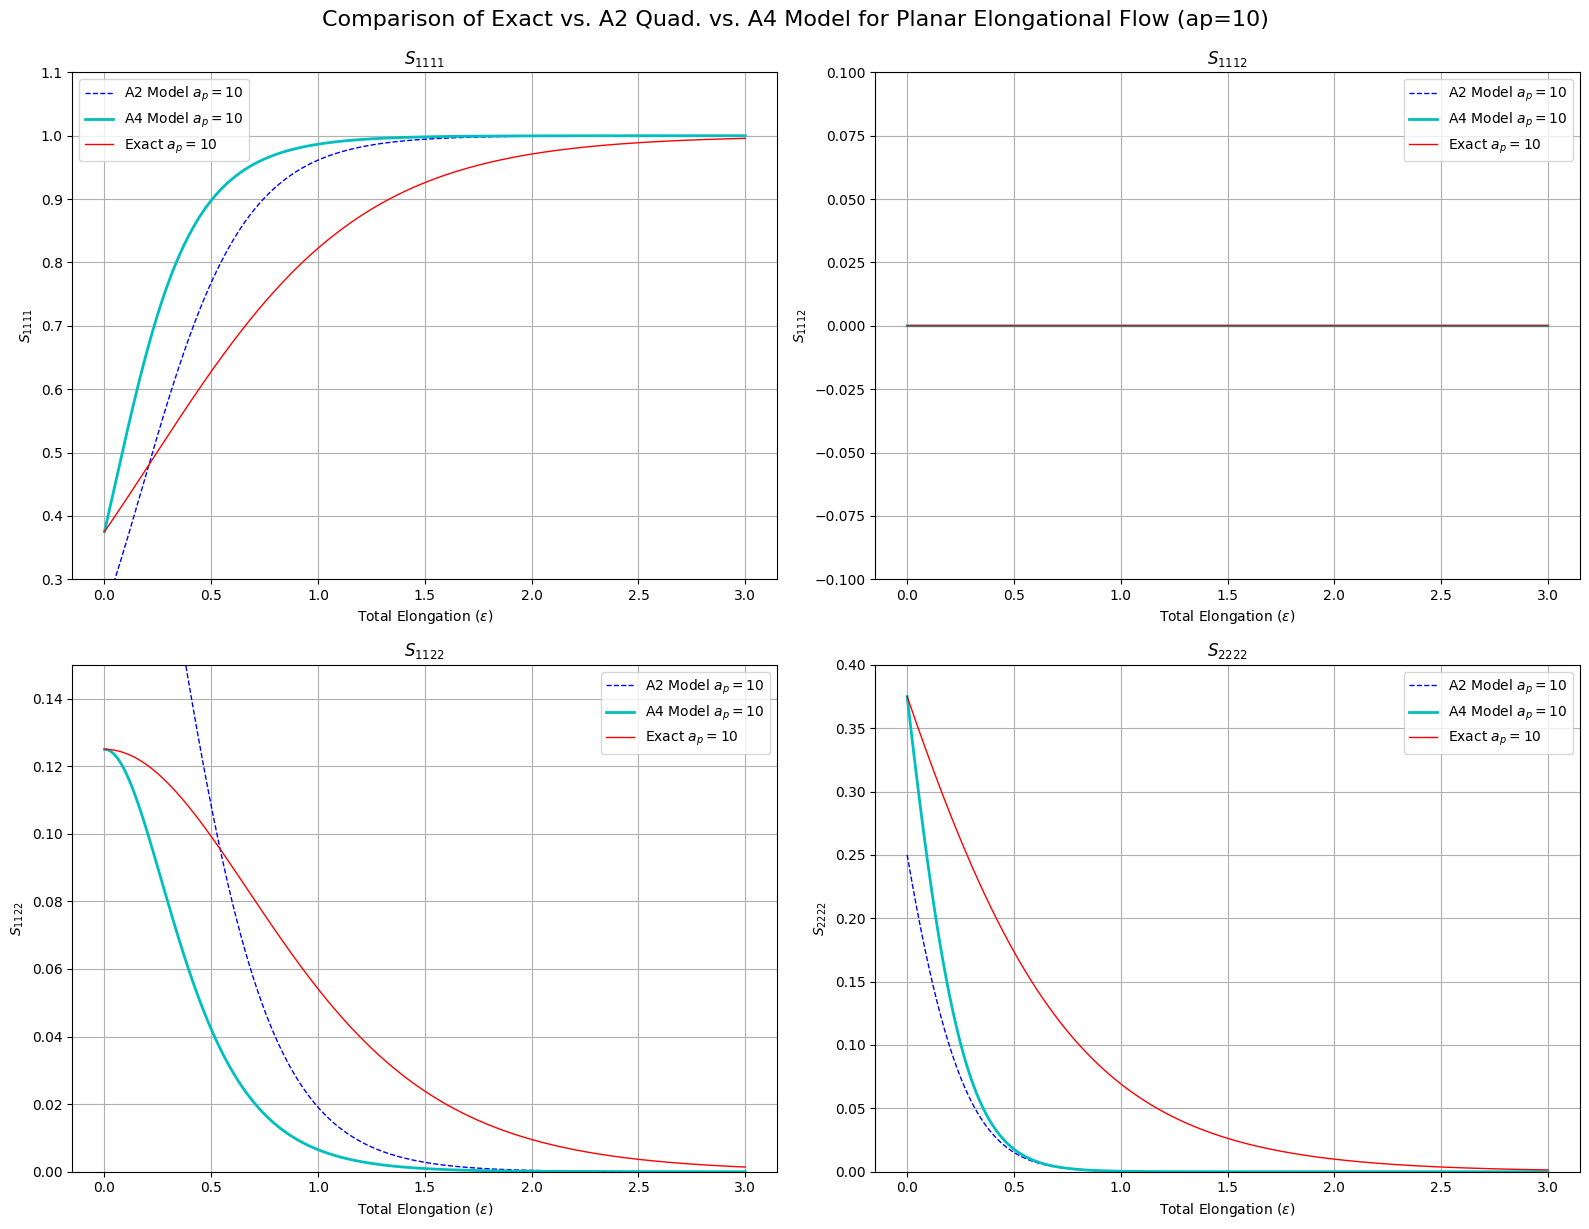


Data generated and saved. You can now use these VTK files to create glyphs in VisIt:
- orientation_tensors_shear_ap10.vtk
- orientation_tensors_elongation_ap10.vtk


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import pandas as pd
import pyvista as pv

A_RANDOM_INITIAL_2D = np.array([[0.5, 0.0],
                                [0.0, 0.5]])

S_1111_RANDOM = 0.375
S_1112_RANDOM = 0.0
S_1122_RANDOM = 0.125
S_2222_RANDOM = 0.375
S_1222_RANDOM = 0.0

A4_RANDOM_INITIAL_FLAT = np.array([
    S_1111_RANDOM,
    S_1112_RANDOM,
    S_1122_RANDOM,
    S_1222_RANDOM,
    S_2222_RANDOM
])

EPSILON = 1e-10

def calculate_lambda(ap):
    if ap == 1:
        return 0.0
    else:
        return (ap**2 - 1) / (ap**2 + 1)

def get_L_simple_shear_2d(shear_rate):
    return np.array([[0, shear_rate],
                     [0, 0]])

def get_L_planar_elongational_2d(strain_rate):
    return np.array([[strain_rate, 0],
                     [0, -strain_rate]])

def quadratic_closure_A4_for_A2_model(A2_tensor):
    A = A2_tensor
    A4_closed = np.einsum('ik,jl->ijkl', A, A)
    return A4_closed

def jeffrey_ode_func_2d(A_flat, t, L_tensor, lambda_val):
    A = A_flat.reshape((2, 2))
    W = 0.5 * (L_tensor - L_tensor.T)
    D = 0.5 * (L_tensor + L_tensor.T)
    L_prime_tensor = W + lambda_val * D
    term_L_prime_S = np.einsum('im,mj->ij', L_prime_tensor, A) + \
                     np.einsum('jm,mi->ij', L_prime_tensor, A)
    closure_term = -2 * lambda_val * np.einsum('kl,kl->', D, A) * A
    dA_dt = term_L_prime_S + closure_term
    return dA_dt.flatten()

def A4_from_A2_quadratic_closure(A2_tensor):
    A11 = A2_tensor[0, 0]
    A12 = A2_tensor[0, 1]
    A22 = A2_tensor[1, 1]
    S1111_approx = A11 * A11
    S1112_approx = A11 * A12
    S1122_approx = A11 * A22
    S2222_approx = A22 * A22
    return S1111_approx, S1112_approx, S1122_approx, S2222_approx

def reconstruct_A4(A4_flat):
    A4 = np.zeros((2,2,2,2))
    A1111, A1112, A1122, A1222, A2222 = A4_flat
    A4[0,0,0,0] = A1111
    A4[0,0,0,1] = A1112; A4[0,0,1,0] = A1112; A4[0,1,0,0] = A1112; A4[1,0,0,0] = A1112
    A4[0,0,1,1] = A1122; A4[0,1,0,1] = A1122; A4[0,1,1,0] = A1122; A4[1,0,0,1] = A1122; A4[1,0,1,0] = A1122; A4[1,1,0,0] = A1122
    A4[1,1,1,1] = A2222
    A4[0,1,1,1] = A1222; A4[1,0,1,1] = A1222; A4[1,1,0,1] = A1222; A4[1,1,1,0] = A1222
    return A4

def get_A2_from_A4(A4_tensor):
    A2 = np.zeros((2,2))
    A2[0,0] = A4_tensor[0,0,0,0] + A4_tensor[0,1,1,0]
    A2[0,1] = A4_tensor[0,0,0,1] + A4_tensor[0,1,1,1]
    A2[1,0] = A4_tensor[1,0,0,0] + A4_tensor[1,1,1,0]
    A2[1,1] = A4_tensor[1,0,0,1] + A4_tensor[1,1,1,1]
    return A2

def jeffrey_ode_func_A4(A4_flat, t, L_tensor, lambda_val):
    A4 = reconstruct_A4(A4_flat)
    A2 = get_A2_from_A4(A4)
    W = 0.5 * (L_tensor - L_tensor.T)
    D = 0.5 * (L_tensor + L_tensor.T)
    L_prime_tensor = W + lambda_val * D
    term_hydrodynamic = np.einsum('im,mjkl->ijkl', L_prime_tensor, A4) + \
                        np.einsum('jm,imkl->ijkl', L_prime_tensor, A4) + \
                        np.einsum('km,ijml->ijkl', L_prime_tensor, A4) + \
                        np.einsum('lm,ijkm->ijkl', L_prime_tensor, A4)
    closure_term_A6 = -4 * lambda_val * np.einsum('rs,rs->', D, A2) * A4
    dA4_dt_tensor = term_hydrodynamic + closure_term_A6
    d_A4_dt_flat = np.array([
        dA4_dt_tensor[0,0,0,0],
        dA4_dt_tensor[0,0,0,1],
        dA4_dt_tensor[0,0,1,1],
        dA4_dt_tensor[0,1,1,1],
        dA4_dt_tensor[1,1,1,1]
    ])
    return d_A4_dt_flat

def calculate_shear_params_exact(gamma, ap):
    lam = calculate_lambda(ap)
    if np.isclose(lam, 1.0):
        wt_val = 0.0
    else:
        wt_val = (gamma / 2) * np.sqrt(1 - lam**2 + EPSILON)
    a1 = 1 - (2 * lam / (1 + lam)) * np.sin(wt_val)**2
    a2 = - (2 * lam / np.sqrt(1 - lam**2 + EPSILON)) * np.sin(2 * wt_val)
    a3 = 1 + (2 * lam / (1 - lam + EPSILON)) * np.sin(wt_val)**2
    return a1, a2, a3, wt_val

def S_ijkl_shear_exact(gamma, ap):
    if np.isclose(gamma, 0.0):
        return S_1111_RANDOM, S_1112_RANDOM, S_1122_RANDOM, S_1222_RANDOM, S_2222_RANDOM
    a1, a2, a3, wt_val = calculate_shear_params_exact(gamma, ap)
    if ap != 1 and np.isclose(np.sin(wt_val), 0.0, atol=1e-3):
         return S_1111_RANDOM, S_1112_RANDOM, S_1122_RANDOM, S_1222_RANDOM, S_2222_RANDOM
    common_denom_term = (a1 + a3)**2 - 4
    if np.isclose(common_denom_term, 0.0, atol=EPSILON):
        return S_1111_RANDOM, S_1112_RANDOM, S_1122_RANDOM, S_1222_RANDOM, S_2222_RANDOM
    S1111 = (a1 + a3 - 2)**2 * (4 + a1 + 5 * a3 + 2 * a3**2) / (2 * common_denom_term**2 + EPSILON)
    S1112 = - (a1 + a3 - 2)**2 * a2 * (1 + a3) / (2 * common_denom_term**2 + EPSILON)
    S1122 = (a1 + a3 - 2)**2 * (a1 + 2 * a1 * a3 + a3) / (2 * common_denom_term**2 + EPSILON)
    S1222 = - (a1 + a3 - 2)**2 * a2 * (1 + a3) / (2 * common_denom_term**2 + EPSILON)
    S2222 = (a1 + a3 - 2)**2 * (4 + 2 * a1**2 + 5 * a1 + a3) / (2 * common_denom_term**2 + EPSILON)
    return S1111, S1112, S1122, S1222, S2222

def calculate_elongation_params_exact(epsilon, ap):
    lam = calculate_lambda(ap)
    wt_val = lam * epsilon
    a1 = np.exp(-2 * wt_val)
    a2 = 0.0
    a3 = np.exp(2 * wt_val)
    return a1, a2, a3

def S_ijkl_elongation_exact(epsilon, ap):
    if np.isclose(epsilon, 0.0):
        return S_1111_RANDOM, S_1112_RANDOM, S_1122_RANDOM, S_1222_RANDOM, S_2222_RANDOM
    a1, a2, a3 = calculate_elongation_params_exact(epsilon, ap)
    common_denom_term = (a1 - a3)**2
    if np.isclose(common_denom_term, 0.0, atol=EPSILON):
        return S_1111_RANDOM, S_1112_RANDOM, S_1122_RANDOM, S_1222_RANDOM, S_2222_RANDOM
    S1111 = (a1 - 3 * a3 + 2 * a3**2) / (2 * common_denom_term + EPSILON)
    S1112 = 0.0
    S1122 = (a1 - 2 * a1 * a3 + a3) / (2 * common_denom_term + EPSILON)
    S1222 = 0.0
    S2222 = (2 * a1**2 - 3 * a1 + a3) / (2 * common_denom_term + EPSILON)
    return S1111, S1112, S1122, S1222, S2222

def calculate_mape(exact_values, predicted_values, threshold=1e-8):
    exact_np = np.array(exact_values)
    predicted_np = np.array(predicted_values)
    valid_indices = np.abs(exact_np) > threshold
    if np.sum(valid_indices) == 0:
        return np.nan
    percentage_errors = (np.abs(predicted_np[valid_indices] - exact_np[valid_indices]) / np.abs(exact_np[valid_indices])) * 100
    return np.mean(percentage_errors)

def pad_2d_tensor_to_3d(tensor_2d):
    """
    Pads a 2x2 symmetric orientation tensor to a 3x3 matrix assuming
    the out-of-plane orientation is isotropic and the trace is 1.
    """
    tensor_3d = np.zeros((3, 3))
    tensor_3d[:2, :2] = tensor_2d
    trace_2d = np.trace(tensor_2d)
    # The sum of all diagonal components must be 1.
    tensor_3d[2, 2] = 1.0 - trace_2d
    return tensor_3d

def save_tensor_data_to_vtk(flow_type, ap):
    """
    Simulates the Jeffery's model and saves the time-series data as a VTK PolyData file.

    This function creates a PyVista PolyData with each point representing a time step
    and attaches the calculated orientation tensors as point data.
    """
    if flow_type == 'shear':
        time_points = np.linspace(0, 160, 2000)
        shear_rate_val = 1.0
        L_flow = get_L_simple_shear_2d(shear_rate=shear_rate_val)
    elif flow_type == 'elongation':
        time_points = np.linspace(0, 3.0, 2000)
        strain_rate_val = 1.0
        L_flow = get_L_planar_elongational_2d(strain_rate=strain_rate_val)
    else:
        raise ValueError("Invalid flow_type. Choose 'shear' or 'elongation'.")

    lam = calculate_lambda(ap)
    sol_A4 = odeint(jeffrey_ode_func_A4, A4_RANDOM_INITIAL_FLAT, time_points, args=(L_flow, lam))

    A_ij_A4_model = []
    for a4_flat in sol_A4:
        a4_tensor = reconstruct_A4(a4_flat)
        a2_tensor = get_A2_from_A4(a4_tensor)
        A_ij_A4_model.append(a2_tensor)
    A_ij_A4_model = np.array(A_ij_A4_model)

    # 1. Create a set of points for the PolyData object
    points = np.zeros((len(time_points), 3))
    points[:, 0] = time_points

    # 2. Pad the 2x2 tensors to a 3x3 symmetric matrix for 3D visualization
    A_tensor_3x3_A4 = np.zeros((len(time_points), 3, 3))
    for i, tensor_2d in enumerate(A_ij_A4_model):
        A_tensor_3x3_A4[i] = pad_2d_tensor_to_3d(tensor_2d)

    flattened_tensors = A_tensor_3x3_A4.reshape(-1, 9)

    # 3. Create the PolyData object and add the tensor data
    polydata = pv.PolyData(points)
    polydata.point_data['A_ij_Tensors'] = flattened_tensors

    # 4. Save the file in VTK format as ASCII
    file_name = f'orientation_tensors_{flow_type}_ap{ap}.vtk'
    polydata.save(file_name, binary=False)

    print(f"PolyData VTK data saved to {file_name}")
    return file_name

def plot_comparison_shear_all_models():
    shear_rates = np.linspace(0, 160, 2000)
    aspect_ratios = [10]
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    component_titles = ['$S_{1111}$', '$S_{1112}$', '$S_{1122}$', '$S_{2222}$']
    y_limits_shear = {
        '$S_{1111}$': (0.0, 1.1),
        '$S_{1112}$': (-0.3, 0.5),
        '$S_{1122}$': (0.0, 0.3),
        '$S_{2222}$': (0.0, 0.6)
    }
    print("\n--- Simple Shear Flow: RMSE and MAPE Errors ---")
    for i, title in enumerate(component_titles):
        ax = axes[i]
        ax.set_title(title)
        ax.set_xlabel('Total Shear ($\gamma$)')
        ax.set_ylabel(title)
        ax.grid(True)
        ax.set_ylim(y_limits_shear[title])
        for ap in aspect_ratios:
            lam = calculate_lambda(ap)
            shear_rate_val = 1.0
            L_shear = get_L_simple_shear_2d(shear_rate=shear_rate_val)
            sol_quad_a2 = odeint(jeffrey_ode_func_2d, A_RANDOM_INITIAL_2D.flatten(), shear_rates, args=(L_shear, lam))
            ode_s_data_quad_a2 = []
            for j, gamma in enumerate(shear_rates):
                A_current = sol_quad_a2[j].reshape((2, 2))
                s1111, s1112, s1122, s2222 = A4_from_A2_quadratic_closure(A_current)
                if title == '$S_{1111}$': ode_s_data_quad_a2.append(s1111)
                elif title == '$S_{1112}$': ode_s_data_quad_a2.append(s1112)
                elif title == '$S_{1122}$': ode_s_data_quad_a2.append(s1122)
                elif title == '$S_{2222}$': ode_s_data_quad_a2.append(s2222)
            ax.plot(shear_rates, ode_s_data_quad_a2, 'b--', label=f'A2 Model $a_p={ap}$', linewidth=1)
            sol_A4 = odeint(jeffrey_ode_func_A4, A4_RANDOM_INITIAL_FLAT, shear_rates, args=(L_shear, lam))
            ode_s_data_A4 = []
            for j, gamma in enumerate(shear_rates):
                A4_current_flat = sol_A4[j]
                A4_current = reconstruct_A4(A4_current_flat)
                s1111 = A4_current[0,0,0,0]
                s1112 = A4_current[0,0,0,1]
                s1122 = A4_current[0,0,1,1]
                s2222 = A4_current[1,1,1,1]
                if title == '$S_{1111}$': ode_s_data_A4.append(s1111)
                elif title == '$S_{1112}$': ode_s_data_A4.append(s1112)
                elif title == '$S_{1122}$': ode_s_data_A4.append(s1122)
                elif title == '$S_{2222}$': ode_s_data_A4.append(s2222)
            ax.plot(shear_rates, ode_s_data_A4, 'c-', label=f'A4 Model $a_p={ap}$', linewidth=2)
            exact_s_data = []
            for gamma in shear_rates:
                s1111, s1112, s1122, s1222, s2222_exact = S_ijkl_shear_exact(gamma, ap)
                if title == '$S_{1111}$': exact_s_data.append(s1111)
                elif title == '$S_{1112}$': exact_s_data.append(s1112)
                elif title == '$S_{1122}$': exact_s_data.append(s1122)
                elif title == '$S_{2222}$': exact_s_data.append(s2222_exact)
            ax.plot(shear_rates, exact_s_data, 'r-', label=f'Exact $a_p={ap}$', linewidth=1)
            ode_data_np_quad_a2 = np.array(ode_s_data_quad_a2)
            ode_data_np_A4 = np.array(ode_s_data_A4)
            exact_data_np = np.array(exact_s_data)
            valid_indices_rmse = ~np.isnan(ode_data_np_quad_a2) & ~np.isnan(exact_data_np)
            if np.sum(valid_indices_rmse) > 0:
                rmse_quad_a2 = np.sqrt(np.mean((ode_data_np_quad_a2[valid_indices_rmse] - exact_data_np[valid_indices_rmse])**2))
            else:
                rmse_quad_a2 = np.nan
            mape_quad_a2 = calculate_mape(exact_data_np, ode_data_np_quad_a2)
            print(f"  A2 Model {title} (ap={ap}): RMSE = {rmse_quad_a2:.6f}, MAPE = {mape_quad_a2:.2f}%")
            valid_indices_rmse = ~np.isnan(ode_data_np_A4) & ~np.isnan(exact_data_np)
            if np.sum(valid_indices_rmse) > 0:
                rmse_A4 = np.sqrt(np.mean((ode_data_np_A4[valid_indices_rmse] - exact_data_np[valid_indices_rmse])**2))
            else:
                rmse_A4 = np.nan
            mape_A4 = calculate_mape(exact_data_np, ode_data_np_A4)
            print(f"  A4 Model {title} (ap={ap}): RMSE = {rmse_A4:.6f}, MAPE = {mape_A4:.2f}%")
        ax.legend()
    plt.tight_layout()
    plt.suptitle('Comparison of Exact vs. A2 Quad. vs. A4 Model for Simple Shear Flow (ap=10)', y=1.02, fontsize=16)
    plt.show()

def plot_comparison_elongational_all_models():
    elongation_rates = np.linspace(0, 3.0, 2000)
    aspect_ratios = [10]
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    component_titles = ['$S_{1111}$', '$S_{1112}$', '$S_{1122}$', '$S_{2222}$']
    y_limits_elongational = {
        '$S_{1111}$': (0.3, 1.1),
        '$S_{1112}$': (-0.1, 0.1),
        '$S_{1122}$': (0.0, 0.15),
        '$S_{2222}$': (0.0, 0.4)
    }
    print("\n--- Planar Elongational Flow: RMSE and MAPE Errors ---")
    for i, title in enumerate(component_titles):
        ax = axes[i]
        ax.set_title(title)
        ax.set_xlabel('Total Elongation ($\epsilon$)')
        ax.set_ylabel(title)
        ax.grid(True)
        ax.set_ylim(y_limits_elongational[title])
        for ap in aspect_ratios:
            lam = calculate_lambda(ap)
            strain_rate_val = 1.0
            L_elong = get_L_planar_elongational_2d(strain_rate=strain_rate_val)
            sol_quad_a2 = odeint(jeffrey_ode_func_2d, A_RANDOM_INITIAL_2D.flatten(), elongation_rates, args=(L_elong, lam))
            ode_s_data_quad_a2 = []
            for j, epsilon in enumerate(elongation_rates):
                A_current = sol_quad_a2[j].reshape((2, 2))
                s1111, s1112, s1122, s2222 = A4_from_A2_quadratic_closure(A_current)
                if title == '$S_{1111}$': ode_s_data_quad_a2.append(s1111)
                elif title == '$S_{1112}$': ode_s_data_quad_a2.append(s1112)
                elif title == '$S_{1122}$': ode_s_data_quad_a2.append(s1122)
                elif title == '$S_{2222}$': ode_s_data_quad_a2.append(s2222)
            ax.plot(elongation_rates, ode_s_data_quad_a2, 'b--', label=f'A2 Model $a_p={ap}$', linewidth=1)
            sol_A4 = odeint(jeffrey_ode_func_A4, A4_RANDOM_INITIAL_FLAT, elongation_rates, args=(L_elong, lam))
            ode_s_data_A4 = []
            for j, epsilon in enumerate(elongation_rates):
                A4_current_flat = sol_A4[j]
                A4_current = reconstruct_A4(A4_current_flat)
                s1111 = A4_current[0,0,0,0]
                s1112 = A4_current[0,0,0,1]
                s1122 = A4_current[0,0,1,1]
                s2222 = A4_current[1,1,1,1]
                if title == '$S_{1111}$': ode_s_data_A4.append(s1111)
                elif title == '$S_{1112}$': ode_s_data_A4.append(s1112)
                elif title == '$S_{1122}$': ode_s_data_A4.append(s1122)
                elif title == '$S_{2222}$': ode_s_data_A4.append(s2222)
            ax.plot(elongation_rates, ode_s_data_A4, 'c-', label=f'A4 Model $a_p={ap}$', linewidth=2)
            exact_s_data = []
            for epsilon in elongation_rates:
                s1111, s1112, s1122, s1222, s2222_exact = S_ijkl_elongation_exact(epsilon, ap)
                if title == '$S_{1111}$': exact_s_data.append(s1111)
                elif title == '$S_{1112}$': exact_s_data.append(s1112)
                elif title == '$S_{1122}$': exact_s_data.append(s1122)
                elif title == '$S_{2222}$': exact_s_data.append(s2222_exact)
            ax.plot(elongation_rates, exact_s_data, 'r-', label=f'Exact $a_p={ap}$', linewidth=1)
            ode_data_np_quad_a2 = np.array(ode_s_data_quad_a2)
            ode_data_np_A4 = np.array(ode_s_data_A4)
            exact_data_np = np.array(exact_s_data)
            valid_indices_rmse = ~np.isnan(ode_data_np_quad_a2) & ~np.isnan(exact_data_np)
            if np.sum(valid_indices_rmse) > 0:
                rmse_quad_a2 = np.sqrt(np.mean((ode_data_np_quad_a2[valid_indices_rmse] - exact_data_np[valid_indices_rmse])**2))
            else:
                rmse_quad_a2 = np.nan
            mape_quad_a2 = calculate_mape(exact_data_np, ode_data_np_quad_a2)
            print(f"  A2 Model {title} (ap={ap}): RMSE = {rmse_quad_a2:.6f}, MAPE = {mape_quad_a2:.2f}%")
            valid_indices_rmse = ~np.isnan(ode_data_np_A4) & ~np.isnan(exact_data_np)
            if np.sum(valid_indices_rmse) > 0:
                rmse_A4 = np.sqrt(np.mean((ode_data_np_A4[valid_indices_rmse] - exact_data_np[valid_indices_rmse])**2))
            else:
                rmse_A4 = np.nan
            mape_A4 = calculate_mape(exact_data_np, ode_data_np_A4)
            print(f"  A4 Model {title} (ap={ap}): RMSE = {rmse_A4:.6f}, MAPE = {mape_A4:.2f}%")
        ax.legend()
    plt.tight_layout()
    plt.suptitle('Comparison of Exact vs. A2 Quad. vs. A4 Model for Planar Elongational Flow (ap=10)', y=1.02, fontsize=16)
    plt.show()

if __name__ == "__main__":
    ap = 10
    print("Generating PolyData VTK ASCII data files...")
    shear_vtk_file = save_tensor_data_to_vtk('shear', ap)
    elongation_vtk_file = save_tensor_data_to_vtk('elongation', ap)

    print("\nStarting Matplotlib plotting for Simple Shear Flow...")
    plot_comparison_shear_all_models()
    print("\nStarting Matplotlib plotting for Planar Elongational Flow...")
    plot_comparison_elongational_all_models()

    print("\nData generated and saved. You can now use these VTK files to create glyphs in VisIt:")
    print(f"- {shear_vtk_file}")
    print(f"- {elongation_vtk_file}")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import pandas as pd
import pyvista as pv

# --- INITIAL CONSTANTS AND TENSORS ---
A_RANDOM_INITIAL_2D = np.array([[0.5, 0.0],
                                [0.0, 0.5]])

S_1111_RANDOM = 0.375
S_1112_RANDOM = 0.0
S_1122_RANDOM = 0.125
S_2222_RANDOM = 0.375
S_1222_RANDOM = 0.0

A4_RANDOM_INITIAL_FLAT = np.array([
    S_1111_RANDOM,
    S_1112_RANDOM,
    S_1122_RANDOM,
    S_1222_RANDOM,
    S_2222_RANDOM
])

EPSILON = 1e-10

# --- UTILITY FUNCTIONS ---

def calculate_lambda(ap):
    if ap == 1:
        return 0.0
    else:
        return (ap**2 - 1) / (ap**2 + 1)

def get_L_simple_shear_2d(shear_rate):
    return np.array([[0, shear_rate],
                     [0, 0]])

def get_L_planar_elongational_2d(strain_rate):
    return np.array([[strain_rate, 0],
                     [0, -strain_rate]])

def jeffrey_ode_func_A4(A4_flat, t, L_tensor, lambda_val):
    A4 = reconstruct_A4(A4_flat)
    A2 = get_A2_from_A4(A4)
    W = 0.5 * (L_tensor - L_tensor.T)
    D = 0.5 * (L_tensor + L_tensor.T)
    L_prime_tensor = W + lambda_val * D
    term_hydrodynamic = np.einsum('im,mjkl->ijkl', L_prime_tensor, A4) + \
                        np.einsum('jm,imkl->ijkl', L_prime_tensor, A4) + \
                        np.einsum('km,ijml->ijkl', L_prime_tensor, A4) + \
                        np.einsum('lm,ijkm->ijkl', L_prime_tensor, A4)
    closure_term_A6 = -4 * lambda_val * np.einsum('rs,rs->', D, A2) * A4
    dA4_dt_tensor = term_hydrodynamic + closure_term_A6
    d_A4_dt_flat = np.array([
        dA4_dt_tensor[0,0,0,0],
        dA4_dt_tensor[0,0,0,1],
        dA4_dt_tensor[0,0,1,1],
        dA4_dt_tensor[0,1,1,1],
        dA4_dt_tensor[1,1,1,1]
    ])
    return d_A4_dt_flat

def reconstruct_A4(A4_flat):
    A4 = np.zeros((2,2,2,2))
    A1111, A1112, A1122, A1222, A2222 = A4_flat
    A4[0,0,0,0] = A1111
    A4[0,0,0,1] = A1112; A4[0,0,1,0] = A1112; A4[0,1,0,0] = A1112; A4[1,0,0,0] = A1112
    A4[0,0,1,1] = A1122; A4[0,1,0,1] = A1122; A4[0,1,1,0] = A1122; A4[1,0,0,1] = A1122; A4[1,0,1,0] = A1122; A4[1,1,0,0] = A1122
    A4[1,1,1,1] = A2222
    A4[0,1,1,1] = A1222; A4[1,0,1,1] = A1222; A4[1,1,0,1] = A1222; A4[1,1,1,0] = A1222
    return A4

def get_A2_from_A4(A4_tensor):
    A2 = np.zeros((2,2))
    A2[0,0] = A4_tensor[0,0,0,0] + A4_tensor[0,1,1,0]
    A2[0,1] = A4_tensor[0,0,0,1] + A4_tensor[0,1,1,1]
    A2[1,0] = A4_tensor[1,0,0,0] + A4_tensor[1,1,1,0]
    A2[1,1] = A4_tensor[1,0,0,1] + A4_tensor[1,1,1,1]
    return A2

def pad_2d_tensor_to_3d(tensor_2d):
    """
    Pads a 2x2 symmetric orientation tensor to a 3x3 matrix ensuring
    the trace is 1 (A_11 + A_22 + A_33 = 1) to avoid a collapsed ellipsoid.
    """
    tensor_3d = np.zeros((3, 3))
    tensor_3d[:2, :2] = tensor_2d
    trace_2d = np.trace(tensor_2d)
    # The A_33 component is set to preserve the trace = 1 property.
    tensor_3d[2, 2] = 1.0 - trace_2d
    return tensor_3d

# The plotting and error comparison functions are omitted as they are not
# required for the final visualization file generation.

# --- MAIN VISUALIZATION FUNCTION ---

def create_2d_domain_vtk(flow_type, ap, domain_size=(20, 20), final_time=160.0):
    """
    Calculates the final state orientation tensor and maps it onto a 2D spatial
    domain, saving the data as an ASCII VTK file (PolyData) compatible with VisIt.
    """
    if flow_type == 'shear':
        L_flow = get_L_simple_shear_2d(shear_rate=1.0)
        time_points = np.linspace(0, final_time, 2000)
    elif flow_type == 'elongation':
        L_flow = get_L_planar_elongational_2d(strain_rate=1.0)
        time_points = np.linspace(0, final_time, 2000)
    else:
        raise ValueError("Invalid flow_type. Choose 'shear' or 'elongation'.")

    lam = calculate_lambda(ap)

    # 1. Solve ODE up to final time to get the final tensor state
    sol_A4 = odeint(jeffrey_ode_func_A4, A4_RANDOM_INITIAL_FLAT, time_points, args=(L_flow, lam))
    final_A4_flat = sol_A4[-1]
    final_A4_tensor = reconstruct_A4(final_A4_flat)
    final_A2_tensor_2d = get_A2_from_A4(final_A4_tensor)

    # 2. Pad to 3x3 matrix for 3D visualization
    final_A2_tensor_3d = pad_2d_tensor_to_3d(final_A2_tensor_2d)
    final_flattened_tensor = final_A2_tensor_3d.reshape(9)

    # 3. Create a 2D spatial domain (grid of points)
    nx, ny = domain_size
    x = np.linspace(-1.0, 1.0, nx)
    y = np.linspace(-1.0, 1.0, ny)
    x_grid, y_grid = np.meshgrid(x, y)

    # Reshape points to (N, 3) for PyVista (Z-coordinate is 0)
    points = np.zeros((nx * ny, 3))
    points[:, 0] = x_grid.flatten()
    points[:, 1] = y_grid.flatten()

    # 4. Assign the final tensor state to every point
    num_points = nx * ny
    tensors_array = np.tile(final_flattened_tensor, (num_points, 1))

    # 5. Create the PyVista PolyData
    polydata = pv.PolyData(points)
    polydata.point_data['A_ij_Tensors'] = tensors_array

    # 6. Save the file in VTK format (ASCII)
    file_name = f'domain_tensor_field_{flow_type}_ap{ap}_t{final_time:.0f}.vtk'
    polydata.save(file_name, binary=False)

    print(f"2D domain tensor field VTK data saved to {file_name}")
    print(f"Tensor assigned to all points (Final State): \n{final_A2_tensor_3d}")
    return file_name

if __name__ == "__main__":
    ap = 10
    final_time_shear = 0.1
    final_time_elong = 3.0
    domain_res = (20, 20) # 20x20 grid of points for the domain

    print("Generating 2D domain VTK ASCII data files (PolyData format)...")

    # Shear Flow Example
    shear_vtk_file = create_2d_domain_vtk(
        flow_type='shear',
        ap=ap,
        domain_size=domain_res,
        final_time=final_time_shear
    )

    # Elongational Flow Example
    elongation_vtk_file = create_2d_domain_vtk(
        flow_type='elongation',
        ap=ap,
        domain_size=domain_res,
        final_time=final_time_elong
    )

    print("\nData generated and saved. You can now open these VTK files in VisIt:")
    print(f"- {shear_vtk_file}")
    print(f"- {elongation_vtk_file}")

Generating 2D domain VTK ASCII data files (PolyData format)...
2D domain tensor field VTK data saved to domain_tensor_field_shear_ap10_t0.vtk
Tensor assigned to all points (Final State): 
[[5.03640689e-01 7.28113422e-02 0.00000000e+00]
 [7.28113422e-02 4.96359311e-01 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.22044605e-16]]
2D domain tensor field VTK data saved to domain_tensor_field_elongation_ap10_t3.vtk
Tensor assigned to all points (Final State): 
[[9.99997402e-01 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.59759428e-06 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]]

Data generated and saved. You can now open these VTK files in VisIt:
- domain_tensor_field_shear_ap10_t0.vtk
- domain_tensor_field_elongation_ap10_t3.vtk


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import pyvista as pv

# --- INITIAL CONSTANTS AND TENSORS ---
A_RANDOM_INITIAL_2D = np.array([[0.5, 0.0],
                                [0.0, 0.5]])

S_1111_RANDOM = 0.375
S_1112_RANDOM = 0.0
S_1122_RANDOM = 0.125
S_2222_RANDOM = 0.375
S_1222_RANDOM = 0.0

A4_RANDOM_INITIAL_FLAT = np.array([
    S_1111_RANDOM,
    S_1112_RANDOM,
    S_1122_RANDOM,
    S_1222_RANDOM,
    S_2222_RANDOM
])

EPSILON = 1e-10

# --- UTILITY FUNCTIONS (Same as before) ---

def calculate_lambda(ap):
    if ap == 1:
        return 0.0
    else:
        return (ap**2 - 1) / (ap**2 + 1)

def get_L_simple_shear_2d(shear_rate):
    return np.array([[0, shear_rate],
                     [0, 0]])

def get_L_planar_elongational_2d(strain_rate):
    return np.array([[strain_rate, 0],
                     [0, -strain_rate]])

def jeffrey_ode_func_A4(A4_flat, t, L_tensor, lambda_val):
    A4 = reconstruct_A4(A4_flat)
    A2 = get_A2_from_A4(A4)
    W = 0.5 * (L_tensor - L_tensor.T)
    D = 0.5 * (L_tensor + L_tensor.T)
    L_prime_tensor = W + lambda_val * D
    term_hydrodynamic = np.einsum('im,mjkl->ijkl', L_prime_tensor, A4) + \
                        np.einsum('jm,imkl->ijkl', L_prime_tensor, A4) + \
                        np.einsum('km,ijml->ijkl', L_prime_tensor, A4) + \
                        np.einsum('lm,ijkm->ijkl', L_prime_tensor, A4)
    closure_term_A6 = -4 * lambda_val * np.einsum('rs,rs->', D, A2) * A4
    dA4_dt_tensor = term_hydrodynamic + closure_term_A6
    d_A4_dt_flat = np.array([
        dA4_dt_tensor[0,0,0,0],
        dA4_dt_tensor[0,0,0,1],
        dA4_dt_tensor[0,0,1,1],
        dA4_dt_tensor[0,1,1,1],
        dA4_dt_tensor[1,1,1,1]
    ])
    return d_A4_dt_flat

def reconstruct_A4(A4_flat):
    A4 = np.zeros((2,2,2,2))
    A1111, A1112, A1122, A1222, A2222 = A4_flat
    A4[0,0,0,0] = A1111
    A4[0,0,0,1] = A1112; A4[0,0,1,0] = A1112; A4[0,1,0,0] = A1112; A4[1,0,0,0] = A1112
    A4[0,0,1,1] = A1122; A4[0,1,0,1] = A1122; A4[0,1,1,0] = A1122; A4[1,0,0,1] = A1122; A4[1,0,1,0] = A1122; A4[1,1,0,0] = A1122
    A4[1,1,1,1] = A2222
    A4[0,1,1,1] = A1222; A4[1,0,1,1] = A1222; A4[1,1,0,1] = A1222; A4[1,1,1,0] = A1222
    return A4

def get_A2_from_A4(A4_tensor):
    A2 = np.zeros((2,2))
    A2[0,0] = A4_tensor[0,0,0,0] + A4_tensor[0,1,1,0]
    A2[0,1] = A4_tensor[0,0,0,1] + A4_tensor[0,1,1,1]
    A2[1,0] = A4_tensor[1,0,0,0] + A4_tensor[1,1,1,0]
    A2[1,1] = A4_tensor[1,0,0,1] + A4_tensor[1,1,1,1]
    return A2

def pad_2d_tensor_to_3d(tensor_2d):
    """
    Pads a 2x2 symmetric orientation tensor to a 3x3 matrix ensuring
    the trace is 1 (A_11 + A_22 + A_33 = 1) for 3D visualization.
    """
    tensor_3d = np.zeros((3, 3))
    tensor_3d[:2, :2] = tensor_2d
    trace_2d = np.trace(tensor_2d)
    # The A_33 component is set to preserve the trace = 1 property.
    tensor_3d[2, 2] = 1.0 - trace_2d
    return tensor_3d

# --- MAIN VISUALIZATION FUNCTION (Modified for ap domain) ---

def create_ap_domain_vtk(flow_type, ap_min, ap_max, num_ap_steps, final_time=160.0):
    """
    Calculates the steady-state orientation tensor for a range of aspect ratios (ap)
    and saves the data as an ASCII PolyData (.vtk) file.

    The 'domain' is a 1D line where the x-coordinate corresponds to ap.
    """

    # 1. Define the range of aspect ratios
    ap_values = np.linspace(ap_min, ap_max, num_ap_steps)

    # Determine flow parameters
    if flow_type == 'shear':
        L_flow = get_L_simple_shear_2d(shear_rate=1.0)
        # Use a long time for shear to ensure steady-state or oscillating state is reached
        final_time = 160.0
    elif flow_type == 'elongation':
        L_flow = get_L_planar_elongational_2d(strain_rate=1.0)
        # Elongation reaches steady-state quickly (or diverges for ap=1)
        final_time = 3.0
    else:
        raise ValueError("Invalid flow_type. Choose 'shear' or 'elongation'.")

    time_points = np.linspace(0, final_time, 2000)

    all_tensors_3d = []

    # 2. Calculate steady-state tensor for each ap value
    for ap in ap_values:
        lam = calculate_lambda(ap)

        # Solve ODE
        sol_A4 = odeint(jeffrey_ode_func_A4, A4_RANDOM_INITIAL_FLAT, time_points, args=(L_flow, lam))

        # Get the final tensor state (Steady-State or end of integration)
        final_A4_flat = sol_A4[-1]
        final_A4_tensor = reconstruct_A4(final_A4_flat)
        final_A2_tensor_2d = get_A2_from_A4(final_A4_tensor)

        # Pad to 3x3 matrix for 3D visualization
        final_A2_tensor_3d = pad_2d_tensor_to_3d(final_A2_tensor_2d)
        all_tensors_3d.append(final_A2_tensor_3d)

    all_tensors_3d = np.array(all_tensors_3d)

    # 3. Create 1D domain points (x-coordinate is ap value)
    num_points = len(ap_values)
    points = np.zeros((num_points, 3))

    # Use ap_values as the x-coordinate for visualization
    points[:, 0] = ap_values

    # 4. Flatten the 3x3 tensors to a (N, 9) array
    flattened_tensors = all_tensors_3d.reshape(-1, 9)

    # 5. Create the PyVista PolyData object
    polydata = pv.PolyData(points)
    polydata.point_data['A_ij_Tensors'] = flattened_tensors
    polydata.point_data['ap_values'] = ap_values # Save ap as scalar data for coloring

    # 6. Save the file in VTK PolyData format as ASCII
    file_name = f'ap_sweep_tensor_field_{flow_type}.vtk'
    polydata.save(file_name, binary=False)

    print(f"Aspect ratio sweep tensor field VTK data saved to {file_name}")
    print(f"Domain is a 1D line where X-coordinate = aspect ratio (ap).")
    return file_name

if __name__ == "__main__":

    ap_range = (1.1, 30.0) # Aspect ratio from near-sphere (1.1) to high-aspect (30)
    num_ap_points = 50     # Number of ellipsoids to visualize

    print("Generating VTK ASCII data files for Aspect Ratio Sweep...")

    # Shear Flow Example
    shear_vtk_file = create_ap_domain_vtk(
        flow_type='shear',
        ap_min=ap_range[0],
        ap_max=ap_range[1],
        num_ap_steps=num_ap_points
    )

    # Elongational Flow Example
    elongation_vtk_file = create_ap_domain_vtk(
        flow_type='elongation',
        ap_min=ap_range[0],
        ap_max=ap_range[1],
        num_ap_steps=num_ap_points
    )

    print("\nData generated and saved. Open these VTK files in VisIt:")
    print(f"- {shear_vtk_file}")
    print(f"- {elongation_vtk_file}")